#  Como a segurança pública interfere na problemática habitacional: Uma análise exploratória em São Paulo.
**Etapa:** Storytelling / Projeto Aplicado I - Mackenzie

**Grupo 17:**
* Allana Rayssa Vieira de Oliveira
* Tawany Nascimento Santos
* Nicole Fernandes Moreira
* Erika Cristina Alves Benesi Gomes

**Professor Orientador:** Ismar Frango Silveira

## 1) O Cenário e o Desafio

A relação entre segurança e habitação em São Paulo é complexa. Intuitivamente, nossa hipótese é que o aumento da criminalidade em uma região deveria reduzir o preço médio de aluguel por m². Mas será que os dados confirmam isso?

Esse é o **"gap"** (a lacuna) que este projeto busca investigar:
> **“Como os índices de criminalidade realmente influenciam o mercado de habitação em São Paulo, especialmente no preço médio de aluguel e na valorização por bairro?”**

Para responder a essa pergunta, precisávamos de uma fonte de dados que fosse referência no mercado imobiliário.

### O Parceiro: QuintoAndar

Escolhemos o **QuintoAndar**, a maior plataforma de moradia da América Latina. A empresa revolucionou o setor usando tecnologia para simplificar o aluguel, mas seu maior ativo para este projeto é o uso inteligente de dados.

O QuintoAndar publica o "Índice de Aluguel", que se tornou uma das principais referências para estudos sobre valorização de imóveis e comportamento urbano.

### A Investigação Começa

Com os dados de preço e valorização do QuintoAndar em mãos, definimos nosso desafio:

> **“E se comparássemos os dados reais do QuintoAndar com os registros oficiais de criminalidade da SSP-SP, o que descobriríamos?”**

A jornada a seguir documenta como cruzamos essas duas fontes de dados para encontrar uma resposta, que se mostrou muito mais complexa e surpreendente do que imaginávamos.

# 2) Importação das bibliotecas e configuração do ambiente
Antes de começar a explorar os dados, precisamos das ferramentas certas:

*  **pandas:** manipulação e análise de tabelas;

*  **os:** interação com o sistema de arquivos;

*  **re:** uso de expressões regulares para padronizar textos;

*  **unidecode:** remoção de acentos e caracteres especiais;

*  **matplotlib.pyplot** e **seaborn:** criação e personalização de gráficos.

In [25]:
# --- IMPORTS INICIAIS ---
# OBJETIVO: Importar bibliotecas essenciais.
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#Garantindo a instalação do unidecode, O bloco try/except verifica se a biblioteca já está instalada.
# Caso não esteja, ela é instalada automaticamente e depois importada.
try:
    import unidecode
except:
  # Instala a biblioteca, caso não exista no ambiente
    !pip install --quiet unidecode
    import unidecode
#Configuração do estilo dos gráficos, define o tamanho padrão das figuras do Matplotlib (largura=12, altura=6)
plt.rcParams['figure.figsize'] = (12, 6)
#Define o estilo visual do Seaborn como "whitegrid",que adiciona um fundo branco com grades suaves
sns.set(style="whitegrid")

## 3) Caminhos dos arquivos e leitura

Para responder nossa pergunta, o primeiro passo foi carregar nossos conjuntos de dados. Mas afinal, o que exatamente temos em mãos? Quais informações vieram dessas bases?

O código abaixo carrega os 5 arquivos principais:
1.  `ocorrencias`: Os registros de crimes da SSP-SP.
2.  `dados`: Uma base de imóveis ativos do QuintoAndar em Maio/2023.
3.  `distritos_bairros`: Nossa "tabela de referência" para ligar bairros a distritos policiais.
4.  `quintoAndar`: Relatórios mensais de rankings (ex: bairros mais caros).
5.  `relatorioTri`: Relatórios trimestrais de rentabilidade.

In [26]:
# --- LEITURA DE DADOS ---
# OBJETIVO: Carregar os arquivos diretamente do repositório no GitHub.

# 1. Define os URLs "Raw"
url_ocorrencias = 'https://raw.githubusercontent.com/Allana691/Projeto-aplicado-I/main/dados_ocorrencias_distritos.xlsx'
url_data = 'https://raw.githubusercontent.com/Allana691/Projeto-aplicado-I/main/data.csv'
url_distritos = 'https://raw.githubusercontent.com/Allana691/Projeto-aplicado-I/main/distritos_bairros.xlsx'
url_quintoandar = 'https://raw.githubusercontent.com/Allana691/Projeto-aplicado-I/main/quintoAndar.xlsx'
url_relatorio_tri = 'https://raw.githubusercontent.com/Allana691/Projeto-aplicado-I/main/relatoriosTrimestrais.xlsx'

# 2. Carrega os dados usando os URLs
try:
    ocorrencias = pd.read_excel(url_ocorrencias)
    dados = pd.read_csv(url_data)
    distritos_bairros = pd.read_excel(url_distritos, sheet_name=None)
    quintoAndar = pd.read_excel(url_quintoandar, sheet_name=None)
    relatorioTri = pd.read_excel(url_relatorio_tri, sheet_name=None)

    print("Arquivos carregados com SUCESSO via GitHub!")

except Exception as e:
    print(f"Erro ao carregar arquivos do GitHub. Verifique os links. Erro: {e}")

# --- AGRUPAMENTO INICIAL DE DATASETS ---
# Consolida todas as abas e tabelas carregadas em um único dicionário.
datasets = {
    "ocorrencias": ocorrencias,
    "dados": dados,
    **{f"quintoAndar_{aba}": df for aba, df in quintoAndar.items()},
    **{f"relatorioTri_{aba}": df for aba, df in relatorioTri.items()},
    **{f"distritos_bairros_{aba}": df for aba, df in distritos_bairros.items()}
}
print(f"\nTotal de {len(datasets)} tabelas carregadas no dicionário 'datasets'.")

Arquivos carregados com SUCESSO via GitHub!

Total de 17 tabelas carregadas no dicionário 'datasets'.


Agora que os dados estão carregados, precisamos saber:

> **“O que exatamente temos em mãos? Os dados estão completos ou teremos que tratar muita coisa?”**

Para responder isso, vamos **inspecionar visualmente** as colunas e a primeira linha de cada um dos nossos 5 arquivos principais. Isso nos dará uma visão muito mais clara da estrutura dos dados e de quais abas precisaremos usar.

In [27]:
# --- 3.1: INSPEÇÃO VISUAL DE METADADOS (Versão Corrigida) ---
# OBJETIVO: Mostrar as colunas e a primeira linha de cada dataset principal.

print("--- 1. Inspecionando 'ocorrencias' (dados_ocorrencias_distritos.xlsx) ---")
print(f"Shape (Linhas, Colunas): {ocorrencias.shape}")
print(f"Colunas: {ocorrencias.columns.tolist()}")
print("Primeira linha de dados:")
display(ocorrencias.head(1))
print("\n" + "="*50 + "\n")

print("--- 2. Inspecionando 'dados' (data.csv) ---")
print(f"Shape (Linhas, Colunas): {dados.shape}")
print(f"Colunas: {dados.columns.tolist()}")
print("Primeira linha de dados:")
display(dados.head(1))
print("\n" + "="*50 + "\n")

# Agora para os arquivos com múltiplas abas (sheet_name=None)

print("--- 3. Inspecionando 'quintoAndar.xlsx' (Todas as Abas) ---")
if 'quintoAndar' in locals():
    print(f"Abas (chaves) encontradas: {list(quintoAndar.keys())}\n")
    for aba, df in quintoAndar.items():
        print(f"=== Aba: '{aba}' ===")
        print(f"Shape (Linhas, Colunas): {df.shape}")
        print(f"Colunas: {df.columns.tolist()}")
        print("Primeira linha de dados:")
        display(df.head(1))
        print("\n" + "-"*30 + "\n") # Separador mais curto
else:
    print("Erro: A variável 'quintoAndar' não foi encontrada.")

print("\n" + "="*50 + "\n")

print("--- 4. Inspecionando 'relatorioTri.xlsx' (Todas as Abas) ---")
if 'relatorioTri' in locals():
    print(f"Abas (chaves) encontradas: {list(relatorioTri.keys())}\n")
    for aba, df in relatorioTri.items():
        print(f"=== Aba: '{aba}' ===")
        print(f"Shape (Linhas, Colunas): {df.shape}")
        print(f"Colunas: {df.columns.tolist()}")
        print("Primeira linha de dados:")
        display(df.head(1))
        print("\n" + "-"*30 + "\n") # Separador mais curto
else:
    print("Erro: A variável 'relatorioTri' não foi encontrada.")

print("\n" + "="*50 + "\n")


print("--- 5. Inspecionando 'distritos_bairros.xlsx' (Todas as Abas) ---")
if 'distritos_bairros' in locals():
    print(f"Abas (chaves) encontradas: {list(distritos_bairros.keys())}\n")
    for aba, df in distritos_bairros.items():
        print(f"=== Aba: '{aba}' ===")
        print(f"Shape (Linhas, Colunas): {df.shape}")
        print(f"Colunas: {df.columns.tolist()}")
        print("Primeira linha de dados:")
        display(df.head(1))
        print("\n" + "-"*30 + "\n") # Separador mais curto
else:
    print("Erro: A variável 'distritos_bairros' não foi encontrada.")


print("--- Inspeção de Metadados Concluída ---")

--- 1. Inspecionando 'ocorrencias' (dados_ocorrencias_distritos.xlsx) ---
Shape (Linhas, Colunas): (19205, 22)
Colunas: ['idOcorrenciaMensal', 'idDelito', 'idDistrito', 'ano', 'janeiro', 'fevereiro', 'marco', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro', 'publicado', 'total', 'id_tipo_delito', 'id_grupo_delito', 'tipo_delito', 'ordem_exibicao']
Primeira linha de dados:


,idOcorrenciaMensal,idDelito,idDistrito,ano,janeiro,fevereiro,marco,abril,maio,junho,...,setembro,outubro,novembro,dezembro,publicado,total,id_tipo_delito,id_grupo_delito,tipo_delito,ordem_exibicao
0,0,38,1410,2019,2,1,3,1,1,2,...,1,0,2,2,12,15,38,6,HOMICÍDIO DOLOSO (2),1




--- 2. Inspecionando 'dados' (data.csv) ---
Shape (Linhas, Colunas): (11657, 8)
Colunas: ['address', 'district', 'area', 'bedrooms', 'garage', 'type', 'rent', 'total']
Primeira linha de dados:


,address,district,area,bedrooms,garage,type,rent,total
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939




--- 3. Inspecionando 'quintoAndar.xlsx' (Todas as Abas) ---
Abas (chaves) encontradas: ['Dados Gerais', 'Preço por Tipo', 'Faixa de preço']

=== Aba: 'Dados Gerais' ===
Shape (Linhas, Colunas): (32, 4)
Colunas: ['Mês/Ano', 'Cidade', 'Preço Médio do m² (R$)', 'Variação no Mês (%)']
Primeira linha de dados:


,Mês/Ano,Cidade,Preço Médio do m² (R$),Variação no Mês (%)
0,2023-01-01,São Paulo,42.62,0.95



------------------------------

=== Aba: 'Preço por Tipo' ===
Shape (Linhas, Colunas): (96, 4)
Colunas: ['Mês/Ano', 'Tipo', 'Preço m² (R$)', 'Variação no Mês (%)']
Primeira linha de dados:


,Mês/Ano,Tipo,Preço m² (R$),Variação no Mês (%)
0,2023-01-01,1 Quarto,54.07,0



------------------------------

=== Aba: 'Faixa de preço' ===
Shape (Linhas, Colunas): (225, 6)
Colunas: ['Mês / Ano', 'Tipo de Imóvel', 'area m²', 'Especificação', 'Preço Mínimo (R$)', 'Preço Máximo (R$)']
Primeira linha de dados:


,Mês / Ano,Tipo de Imóvel,area m²,Especificação,Preço Mínimo (R$),Preço Máximo (R$)
0,2023-08-01,1 quarto,45,Sem detalhes,1550,1700



------------------------------



--- 4. Inspecionando 'relatorioTri.xlsx' (Todas as Abas) ---
Abas (chaves) encontradas: ['Preço contrato', 'Preço mediano m2', 'Rentabilidade por quartos', 'Rentabilidade por zona', 'Valores por zona', 'Filtros mais usados', 'Bairros mais procurados', 'Bairros mais caros', 'Bairros mais valorizados', 'Bairros mais desvalorizados']

=== Aba: 'Preço contrato' ===
Shape (Linhas, Colunas): (14, 4)
Colunas: ['Trimestre/Ano', 'Preço (R$/m²)', 'Variação T/T', 'Variação A/A']
Primeira linha de dados:


,Trimestre/Ano,Preço (R$/m²),Variação T/T,Variação A/A
0,1T 2022,6646,3.38,1.69



------------------------------

=== Aba: 'Preço mediano m2' ===
Shape (Linhas, Colunas): (14, 5)
Colunas: ['Trimestre/Ano', 'Preço Anúncio (R$/m²)', 'Variação T/T', 'Variação A/A', 'Desconto']
Primeira linha de dados:


,Trimestre/Ano,Preço Anúncio (R$/m²),Variação T/T,Variação A/A,Desconto
0,1T 2022,7000,4.03,2.67,3.6



------------------------------

=== Aba: 'Rentabilidade por quartos' ===
Shape (Linhas, Colunas): (13, 5)
Colunas: ['Trimestre/Ano', '1 Quarto', '2 Quarto', '3 Quarto', '4 Quarto']
Primeira linha de dados:


,Trimestre/Ano,1 Quarto,2 Quarto,3 Quarto,4 Quarto
0,1T 2022,4.81,5.1,5.0,4.2



------------------------------

=== Aba: 'Rentabilidade por zona' ===
Shape (Linhas, Colunas): (13, 9)
Colunas: ['Trimestre/Ano', 'Centro Sul', 'Centro', 'Centro Oeste', 'Leste I', 'Leste II', 'Norte', 'Oeste', 'Sul']
Primeira linha de dados:


,Trimestre/Ano,Centro Sul,Centro,Centro Oeste,Leste I,Leste II,Norte,Oeste,Sul
0,1T 2022,4.3,5.1,5.1,5.2,5.6,4.9,5.0,4.8



------------------------------

=== Aba: 'Valores por zona' ===
Shape (Linhas, Colunas): (80, 4)
Colunas: ['Região', 'Valor', 'Trimestre', 'Ano']
Primeira linha de dados:


,Região,Valor,Trimestre,Ano
0,Centro Oeste,10379.7,2,2024



------------------------------

=== Aba: 'Filtros mais usados' ===
Shape (Linhas, Colunas): (14, 6)
Colunas: ['rimestre/Ano', '1º lugar', '2º lugar', '3º lugar', '4º lugar', '5º lugar']
Primeira linha de dados:


,rimestre/Ano,1º lugar,2º lugar,3º lugar,4º lugar,5º lugar
0,1T 2022,Apartamento Cobertura,Armário na Cozinha,Armário Embutido no Quarto,Novos ou Reformados,Sol da Manhã



------------------------------

=== Aba: 'Bairros mais procurados' ===
Shape (Linhas, Colunas): (50, 3)
Colunas: ['Bairro', 'Trimestre', 'Ano']
Primeira linha de dados:


,Bairro,Trimestre,Ano
0,Tatuapé,1,2023



------------------------------

=== Aba: 'Bairros mais caros' ===
Shape (Linhas, Colunas): (156, 4)
Colunas: ['bairro', 'valor m/2', 'trimestre', 'ano ']
Primeira linha de dados:


,bairro,valor m/2,trimestre,ano
0,Vila Nova Conceição,13888,1,2025



------------------------------

=== Aba: 'Bairros mais valorizados' ===
Shape (Linhas, Colunas): (59, 4)
Colunas: ['Bairro', 'Variação', 'trimestre', 'ano']
Primeira linha de dados:


,Bairro,Variação,trimestre,ano
0,Sumaré,5.51%,1,2025



------------------------------

=== Aba: 'Bairros mais desvalorizados' ===
Shape (Linhas, Colunas): (40, 4)
Colunas: ['Bairro', 'Variação', 'trimestre', 'ano']
Primeira linha de dados:


,Bairro,Variação,trimestre,ano
0,Alto da Lapa,–1.79%,1,2025



------------------------------



--- 5. Inspecionando 'distritos_bairros.xlsx' (Todas as Abas) ---
Abas (chaves) encontradas: ['Planilha1', 'Bairro']

=== Aba: 'Planilha1' ===
Shape (Linhas, Colunas): (120, 4)
Colunas: ['ID_Distrito', 'Distrito Policial', 'Distrito', 'Nome']
Primeira linha de dados:


,ID_Distrito,Distrito Policial,Distrito,Nome
0,1410,1º DP - Sé,1º DP,Sé



------------------------------

=== Aba: 'Bairro' ===
Shape (Linhas, Colunas): (686, 3)
Colunas: ['Distrito', 'id_distrito', 'Bairro']
Primeira linha de dados:


,Distrito,id_distrito,Bairro
0,5º DP,1015,Aclimação



------------------------------

--- Inspeção de Metadados Concluída ---


### Descoberta (Inspeção Visual)

A inspeção visual revelou alguns pontos cruciais imediatos:

* **`ocorrencias` (Saída 1):** Os dados vêm em formato "largo" (wide), com colunas "janeiro", "fevereiro", etc. Para análise temporal, precisaremos "derretê-los" (melt).
* **`dados` (Saída 2):** Este é o arquivo "snapshot" do Kaggle. As colunas estão em inglês (ex: "district", "area") e precisarão ser renomeadas.

## 4) A Importância da Padronização

A análise de metadados nos mostrou um problema: os nomes dos bairros na base de imóveis (`dados`) não são padronizados. Isso levanta a questão:

>  **“Por que alguns bairros aparecem escritos de maneiras diferentes? Isso pode atrapalhar nossa análise?”**

Sim, isso impossibilitaria nossa análise. Nomes como "Jd. Paulista (Zona Oeste)", "jardim paulista" e "JARDIM PAULISTA" seriam tratados como três lugares diferentes, impedindo o *merge* (junção) com os dados de criminalidade.

O código abaixo executa 3 passos essenciais de limpeza na coluna `bairros`:
1.  **Renomeia** as colunas para português (ex: "district" -> "bairros").
2.  **Remove** textos extras, como "(Zona Oeste)".
3.  **Padroniza** tudo para minúsculas e remove acentos (ex: "Vila Carrão" -> "vila carrao").

In [28]:
# --- RENOMEAÇÃO DE COLUNAS (PADRONIZAÇÃO) ---
novos_nomes = {
    "address": "endereço", "district": "bairros", "area": "área m²",
    "bedrooms": "quartos", "garage": "garagem", "type": "tipo",
    "rent": "aluguel", "total": "total"
}
dados.rename(columns=novos_nomes, inplace=True)
print("Colunas do dataset 'dados' renomeadas:")
print(dados.columns.tolist())

Colunas do dataset 'dados' renomeadas:
['endereço', 'bairros', 'área m²', 'quartos', 'garagem', 'tipo', 'aluguel', 'total']


In [29]:
# --- LIMPEZA E PADRONIZAÇÃO DA COLUNA 'bairros' ---
# OBJETIVO: Garantir que os nomes de bairros fiquem idênticos aos da tabela de referência.

# 0) Cria cópia da coluna original para auditoria
dados["bairros_original"] = dados["bairros"]
print(f"\nTotal de bairros únicos ANTES da limpeza: {dados['bairros_original'].nunique()}")

# 1) Remove informações extras (parênteses) e espaços
dados["bairros"] = dados["bairros"].astype(str).apply(lambda x: re.sub(r"\(.*?\)", "", x).strip())
# 2) Remove acentuação
dados["bairros"] = dados["bairros"].apply(lambda x: unidecode.unidecode(x))
# 3) Converte para minúsculas
dados["bairros"] = dados["bairros"].str.lower()

print(f"Total de bairros únicos DEPOIS da limpeza: {dados['bairros'].nunique()}")
print("\nAmostra de nomes de bairros após limpeza:")
print(dados["bairros"].unique()[:20])


Total de bairros únicos ANTES da limpeza: 1199
Total de bairros únicos DEPOIS da limpeza: 1052

Amostra de nomes de bairros após limpeza:
['belenzinho' 'vila marieta' 'pinheiros' 'vila re' 'bela vista' 'bras'
 'brooklin paulista' 'centro' 'piqueri' 'vila aricanduva' 'se' 'tatuape'
 'lauzane paulista' 'jardim paraventi' 'cambuci' 'liberdade'
 'cidade moncoes' 'agua branca' 'mooca' 'chacara inglesa']


### Descoberta (Limpeza)

O resultado do código confirma a importância da limpeza: o número de bairros únicos caiu drasticamente. Isso mostra que conseguimos agrupar nomes que antes pareciam diferentes, mas se referiam ao mesmo lugar.

Agora, estamos um passo mais perto de poder cruzar as bases. O próximo passo é fazer o mesmo tratamento na nossa "tabela de referência" (`distritos_bairros`).

## 5) Construindo a Ponte (id_distrito)

Temos nossa base de imóveis limpa. Agora, precisamos de uma "ponte" para conectar cada imóvel ao seu respectivo distrito policial. Essa ponte é a tabela `distritos_bairros`.

Mas, para a ponte funcionar, os nomes dos bairros nos dois lados (imóveis e referência) precisam ser *idênticos*.

O código abaixo aplica o mesmo tratamento de limpeza (minúsculas, sem acentos, sem parênteses) na nossa tabela de referência.

In [30]:
# --- PREPARAÇÃO DA TABELA DE REFERÊNCIA DE BAIRROS (distritos_bairros) ---
# OBJETIVO: Selecionar a aba correta e aplicar a mesma limpeza.

# 1) Seleciona a aba "Bairro" que tem o mapeamento [Bairro -> id_distrito]
bairros_ref = distritos_bairros["Bairro"].copy() # Usamos .copy() para evitar warnings

# 2) Preserva a coluna original para auditoria
bairros_ref["Bairro_original"] = bairros_ref["Bairro"]

# 3) Aplica a MESMA limpeza (parênteses, acentos, minúsculas)
bairros_ref["Bairro"] = bairros_ref["Bairro"].astype(str).apply(lambda x: re.sub(r"\(.*?\)", "", x).strip())
bairros_ref["Bairro"] = bairros_ref["Bairro"].apply(lambda x: unidecode.unidecode(x))
bairros_ref["Bairro"] = bairros_ref["Bairro"].str.lower()

# 4) Cria uma lista de bairros válidos que usaremos para filtrar
bairros_validos = bairros_ref["Bairro"].unique().tolist()
print(f"Total de bairros válidos na referência: {len(bairros_validos)}")
print("Amostra da referência após limpeza:")
bairros_ref.head()

Total de bairros válidos na referência: 686
Amostra da referência após limpeza:


,Distrito,id_distrito,Bairro,Bairro_original
0,5º DP,1015,aclimacao,Aclimação
1,7º DP,957,agua branca,Água Branca
2,20º DP,1154,agua fria,Água Fria
3,26º DP,1148,agua funda,Água Funda
4,57º DP,987,agua rasa,Água Rasa


Agora temos os dois lados prontos. A próxima pergunta é:

> **“Como podemos garantir que o bairro de um imóvel corresponde ao mesmo distrito da base de criminalidade?”**

A resposta é o **`merge`** (junção). O código abaixo:
1.  Filtra nossa base de imóveis (`dados`), mantendo apenas os bairros que existem na nossa referência (`bairros_validos`).
2.  Usa o `pd.merge()` para "puxar" o `id_distrito` da tabela de referência para a tabela de imóveis, usando o nome do bairro limpo como chave.
3.  Verifica se algum imóvel ficou sem `id_distrito` correspondente.

In [31]:
# --- FILTRAGEM E JUNÇÃO (MERGE) PARA ADICIONAR id_distrito ---

# 1) Filtra o dataset principal (imóveis) para manter apenas bairros reconhecidos
print(f"Linhas ANTES do filtro de bairros válidos: {dados.shape[0]}")
dados = dados[dados["bairros"].isin(bairros_validos)]
print(f"Linhas DEPOIS do filtro de bairros válidos: {dados.shape[0]}")

# 2) Seleciona apenas as colunas necessárias para o merge (a "ponte")
bairros_ref_subset = bairros_ref[["Bairro", "id_distrito"]]

# 3) JUNÇÃO (MERGE): Adiciona o id_distrito ao dataset de imóveis
dados = dados.merge(bairros_ref_subset,
                    left_on="bairros",    # Chave em 'dados'
                    right_on="Bairro",  # Chave em 'bairros_ref_subset'
                    how="left")         # Mantém todos os imóveis

# 4) Limpa coluna duplicada e verifica nulos
dados.drop(columns=["Bairro"], inplace=True)
nan_count = dados["id_distrito"].isnull().sum()
print(f"\nLinhas com id_distrito NaN (sem correspondência): {nan_count}")

# 5) Remove os imóveis que não tiveram correspondência (se houver)
if nan_count > 0:
    dados = dados.dropna(subset=["id_distrito"])
    print(f"Linhas com NaN removidas. Novas linhas restantes: {dados.shape[0]}")

print("\nMerge concluído! A coluna 'id_distrito' foi adicionada:")
dados.head()

Linhas ANTES do filtro de bairros válidos: 11657
Linhas DEPOIS do filtro de bairros válidos: 10227

Linhas com id_distrito NaN (sem correspondência): 0

Merge concluído! A coluna 'id_distrito' foi adicionada:


,endereço,bairros,área m²,quartos,garagem,tipo,aluguel,total,bairros_original,id_distrito
0,Rua Herval,belenzinho,21,1,0,Studio e kitnet,2400,2939,Belenzinho,925
1,Rua Oscar Freire,pinheiros,18,1,0,Apartamento,4000,4661,Pinheiros,1257
2,Rua Júlio Sayago,vila re,56,2,2,Casa em condomínio,1750,1954,Vila Ré,1153
3,Rua Barata Ribeiro,bela vista,19,1,0,Studio e kitnet,4000,4654,Bela Vista,1410
4,Rua Domingos Paiva,bras,50,2,1,Apartamento,3800,4587,Brás,934


## 6) Organizando os Dados ao Longo do Tempo

Nossos dados de imóveis estão quase prontos. Agora, vamos olhar para os dados de crimes (`ocorrencias`). Eles vieram em um formato "largo" (wide), com colunas "janeiro", "fevereiro", "marco", etc.

Isso é ruim para análises temporais. Precisamos nos perguntar:

> **“De que forma os crimes se distribuem ao longo dos meses? Será que há períodos mais críticos?”**

Para responder isso, precisamos "derreter" (`melt`) a tabela. Queremos um formato "longo" (long), onde cada linha representa um tipo de crime, em um distrito, em um mês específico.

O código abaixo faz essa transformação.

In [32]:
# --- CRIAÇÃO DA VERSÃO "LONG" DAS OCORRÊNCIAS (MELT) ---
# OBJETIVO: Transformar colunas mensais (jan..dez) em linhas (mes, quantidade).

print("Formato original (Wide) dos dados de ocorrências:")
display(ocorrencias.head(2))

# 1) Define colunas de identificação (id_vars) e colunas de valores (value_vars)
colunas_id = ['idOcorrenciaMensal', 'idDelito', 'idDistrito', 'ano',
              'tipo_delito', 'id_tipo_delito', 'id_grupo_delito']
colunas_meses = ['janeiro','fevereiro','marco','abril','maio','junho',
                 'julho','agosto','setembro','outubro','novembro','dezembro']

# 2) Filtra colunas que realmente existem no df
colunas_id_existentes = [col for col in colunas_id if col in ocorrencias.columns]
colunas_meses_existentes = [col for col in colunas_meses if col in ocorrencias.columns]

# 3) Aplica o MELT
ocorrencias_long = ocorrencias.melt(
    id_vars=colunas_id_existentes,
    value_vars=colunas_meses_existentes,
    var_name='mes',
    value_name='quantidade'
)

print("\nFormato transformado (Long) dos dados de ocorrências:")
display(ocorrencias_long.head(5))

print(f"\nShape ANTES do melt: {ocorrencias.shape}")
print(f"Shape DEPOIS do melt: {ocorrencias_long.shape}")

Formato original (Wide) dos dados de ocorrências:


,idOcorrenciaMensal,idDelito,idDistrito,ano,janeiro,fevereiro,marco,abril,maio,junho,...,setembro,outubro,novembro,dezembro,publicado,total,id_tipo_delito,id_grupo_delito,tipo_delito,ordem_exibicao
0,0,38,1410,2019,2,1,3,1,1,2,...,1,0,2,2,12,15,38,6,HOMICÍDIO DOLOSO (2),1
1,0,41,1410,2019,2,1,3,1,1,2,...,1,0,2,2,12,15,41,6,Nº DE VÍTIMAS EM HOMICÍDIO DOLOSO (3),2



Formato transformado (Long) dos dados de ocorrências:


,idOcorrenciaMensal,idDelito,idDistrito,ano,tipo_delito,id_tipo_delito,id_grupo_delito,mes,quantidade
0,0,38,1410,2019,HOMICÍDIO DOLOSO (2),38,6,janeiro,2
1,0,41,1410,2019,Nº DE VÍTIMAS EM HOMICÍDIO DOLOSO (3),41,6,janeiro,2
2,0,72,1410,2019,HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO,72,6,janeiro,0
3,0,73,1410,2019,Nº DE VÍTIMAS EM HOMICÍDIO DOLOSO POR ACIDENTE...,73,6,janeiro,0
4,0,43,1410,2019,HOMICÍDIO CULPOSO POR ACIDENTE DE TRÂNSITO,43,6,janeiro,1



Shape ANTES do melt: (19205, 22)
Shape DEPOIS do melt: (230460, 9)


### Descoberta (Melt)

A transformação foi um sucesso. Passamos de 19.205 linhas (onde cada linha era um tipo de crime por *ano*) para um número muito maior 230.460 linhas, onde cada linha é um tipo de crime por *mês*.

Agora sim podemos analisar tendências mensais e responder perguntas como:

> **“Será que o aumento dos crimes em um mês específico impacta os preços dos imóveis logo depois?”**

Com as duas tabelas (`dados` e `ocorrencias_long`) limpas e estruturadas, podemos começar a análise.

## 7) Análise "Snapshot": Definindo o Caro e o Barato

Agora que os dados estão limpos, vamos começar a primeira etapa da nossa investigação. Usaremos uma metodologia de **"snapshot"**.

**O que é um "snapshot"?**
É uma análise que usa dados de um único ponto no tempo, como uma foto. No nosso caso, é o arquivo `data.csv` (do Kaggle), que representa os anúncios ativos em **05/2023**.

A pergunta que esse snapshot nos ajuda a responder é:
> **"Nesta 'foto' de Maio/2023, quais distritos têm os imóveis mais caros?"**

O código abaixo calcula o `preco_m2` médio por distrito com base nesses dados, criando nosso ranking de preços (o "Reflexo").


In [33]:
# --- MAPA DE NOMES DOS DISTRITOS ---
# OBJETIVO: Criar um dataframe de-para (lookup table) do ID para o Nome do Distrito.

# 1. Seleciona as colunas ('ID_Distrito', 'Nome') da aba 'Planilha1'
mapa_nomes_bruto = distritos_bairros['Planilha1'][['ID_Distrito', 'Nome']]

# 2. Renomeia 'ID_Distrito' -> 'id_distrito' e 'Nome' -> 'nome'
# Isso é feito para que o 'merge' com os rankings funcione
mapa_nomes = mapa_nomes_bruto.rename(columns={
        'ID_Distrito': 'id_distrito',
        'Nome': 'nome'
    }).drop_duplicates()

print("Mapa de nomes (id_distrito -> nome) criado com sucesso!")

# Mostra uma amostra do mapa_nomes que foi criado
print("\nAmostra do 'mapa_nomes' criado:")
display(mapa_nomes.head())

Mapa de nomes (id_distrito -> nome) criado com sucesso!

Amostra do 'mapa_nomes' criado:


,id_distrito,nome
0,1410,Sé
1,1246,Bom Retiro
2,1143,Campos Elíseos
3,1067,Consolação
4,1015,Aclimação


In [34]:
# --- CÁLCULO DO PREÇO POR M² ---
# OBJETIVO: Recarregar dados limpos e calcular preco_m2.

# 1) Calcula preco por m² para cada imóvel
# Filtra área m² > 0 para evitar divisão por zero
dados_limpos = dados[dados['área m²'] > 0].copy()
dados_limpos['preco_m2'] = dados_limpos['aluguel'] / dados_limpos['área m²']
print("Coluna 'preco_m2' calculada.")

# --- RANKING DE PREÇOS (POR DISTRITO) ---
# 2) Ranking de distritos pelo preço médio por m²
ranking_precos_id = (
    dados_limpos.groupby('id_distrito')['preco_m2']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)
ranking_precos_id.rename(columns={'preco_m2': 'preco_m2_medio'}, inplace=True)

# 3) Juntar com o mapa_nomes para mostrar o NOME
ranking_precos_final = pd.merge(
    ranking_precos_id,
    mapa_nomes,
    on='id_distrito',
    how='left'
)

# 4) Selecionar colunas e mostrar Top 10
print("\n--- Top 10 Distritos Mais Caros (Preço Médio m²) ---")
# Usamos .head(10) e mostramos a coluna 'nome'
display(ranking_precos_final[['nome', 'preco_m2_medio']].head(10))

Coluna 'preco_m2' calculada.

--- Top 10 Distritos Mais Caros (Preço Médio m²) ---


,nome,preco_m2_medio
0,Monções,96.251396
1,Itaim Bibi,86.578219
2,Pinheiros,78.127561
3,Jardins,72.878471
4,Consolação,72.754662
5,Vila Clementino,72.091527
6,Perdizes,61.543377
7,Rio Pequeno,59.437416
8,Vila Mariana,58.315011
9,Campo Belo,57.530395


## 8) Mapeando a Criminalidade (O "Espelho" do 1ºQuadri/2023)

Agora que temos o "reflexo" (preços de 05/23), precisamos do "espelho" (os crimes que aconteceram antes).

Para criar um ranking de criminalidade comparável, em vez de usar os crimes de Maio/2023 (o que seria comparar o mesmo período), vamos analisar a criminalidade do **Primeiro Quadrimestre de 2023** (Janeiro, Fevereiro e Março).

A hipótese é que os preços em Maio são um reflexo da percepção de segurança formada nos meses anteriores. O código abaixo filtra os dados do 1Quadri/2023 e os soma por distrito.

In [35]:
# --- PREPARAR RANKING DE CRIMINALIDADE (ESPELHO: 1º Quadrimestre/2023) ---
# OBJETIVO: Criar ranking de criminalidade para Jan, Fev, Mar e Abr de 2023.

# 1) Filtra apenas os dados do primeiro quadrimestre de 2023
meses_jan_abr = ['janeiro', 'fevereiro', 'marco', 'abril'] # <-- MUDANÇA AQUI
ocorrencias_Jan_Abr_2023 = ocorrencias_long[
    (ocorrencias_long['ano'] == 2023) &
    (ocorrencias_long['mes'].isin(meses_jan_abr)) # <-- MUDANÇA AQUI
]

# 2) Agrupa por distrito e soma TODAS as ocorrências do período
ranking_criminalidade_id = (
    ocorrencias_Jan_Abr_2023
    .groupby('idDistrito')['quantidade']
    .sum()
    .reset_index()
    .rename(columns={'quantidade': 'total_ocorrencias_jan_abr_2023', 'idDistrito': 'id_distrito'}) # <-- MUDANÇA AQUI
    .sort_values(by='total_ocorrencias_jan_abr_2023', ascending=False)
)

# 3) Juntar com o mapa_nomes para mostrar o NOME (da Célula 15)
ranking_criminalidade_final = pd.merge(
    ranking_criminalidade_id,
    mapa_nomes,
    on='id_distrito',
    how='left'
)

# 4) Selecionar colunas e mostrar Top 10
print("--- Top 10 Distritos por Criminalidade (Total de Ocorrências no 1º Quadrimestre/2023) ---")
display(ranking_criminalidade_final[['nome', 'total_ocorrencias_jan_abr_2023']].head(10))

--- Top 10 Distritos por Criminalidade (Total de Ocorrências no 1º Quadrimestre/2023) ---


,nome,total_ocorrencias_jan_abr_2023
0,Campos Elíseos,10454
1,Sé,8520
2,Pinheiros,6255
3,Perdizes,5280
4,Consolação,5066
5,Jardins,4932
6,Capão Redondo,4783
7,Pari,4674
8,Campo Limpo,4634
9,Santo Amaro,4013


## 9) A Correlação Inesperada (O Paradoxo)

Temos os dois rankings. Agora, o momento da verdade. Vamos cruzar os dados e responder:

> **“Existe uma relação clara entre segurança e valorização?”**

O código abaixo une os dois rankings (`ranking_precos_id` e `ranking_criminalidade_id`)na tabela `analise_final`.

In [36]:
# --- UNIR RANKING DE PREÇOS E CRIMINALIDADE ---
# OBJETIVO: Fazer merge para ter uma tabela consolidada (Preço Maio/23 vs. Crimes Jan-Abr/23).

# 1) Une os rankings com IDs (para o gráfico da Célula 25)
analise_final = pd.merge(
    ranking_precos_id,
    # *** CORREÇÃO: Usar a nova coluna 'total_ocorrencias_jan_abr_2023' ***
    ranking_criminalidade_id[['id_distrito', 'total_ocorrencias_jan_abr_2023']],
    on='id_distrito',
    how='inner'
)

# 2) Criar uma versão com Nomes apenas para exibição
analise_final_display = pd.merge(
    analise_final,
    mapa_nomes,
    on='id_distrito',
    how='left'
)

# 3) Renomeia a coluna de crimes para a exibição
analise_final_display.rename(columns={'total_ocorrencias_jan_abr_2023': 'total_ocorrencias'}, inplace=True)

# 4) Reordenar e exibir
cols_desejadas = ['nome', 'id_distrito', 'preco_m2_medio', 'total_ocorrencias']
cols_presentes = [col for col in cols_desejadas if col in analise_final_display.columns]

print("Tabela final (Preços 01/05/23 vs. Crimes Jan-Abr/23) pronta para análise:")
display(analise_final_display[cols_presentes].head())

Tabela final (Preços 01/05/23 vs. Crimes Jan-Abr/23) pronta para análise:


,nome,id_distrito,preco_m2_medio,total_ocorrencias
0,Monções,904,96.251396,2598
1,Itaim Bibi,1256,86.578219,3574
2,Pinheiros,1257,78.127561,6255
3,Jardins,937,72.878471,4932
4,Consolação,1067,72.754662,5066


Antes de plotar o gráfico, usamos o `.describe()` para gerar as estatísticas descritivas (incluindo os quartis). Eles nos mostram a **distribuição** dos dados.

In [37]:
# --- ANÁLISE DESCRITIVA (QUARTIS + DECIL) ---
# OBJETIVO: Gerar as estatísticas detalhadas

print("\nEstatísticas para a Análise (Preços Maio/23 vs. Crimes Jan-Abr/23):")

# 1) O .describe() calcula a maioria dos dados (Média, std, Q1, Mediana, Q3)
estatisticas_base = analise_final[['preco_m2_medio', 'total_ocorrencias_jan_abr_2023']].describe()
print("Estatísticas Descritivas (Formatadas):")
display(estatisticas_base.style.format("{:.2f}"))

# 2) O D9 (9º Decil) não vem por padrão, então calculamos separadamente
decil_9 = analise_final['total_ocorrencias_jan_abr_2023'].quantile(0.9)
print(f"\n--- Análise de Outliers (Decil) ---")

# O .2f já estava aplicado aqui no f-string, garantindo 2 casas decimais
print(f"O 9º Decil (D9) das ocorrências (Jan-Abr/2023) é: {decil_9:.2f}")


Estatísticas para a Análise (Preços Maio/23 vs. Crimes Jan-Abr/23):
Estatísticas Descritivas (Formatadas):


,preco_m2_medio,total_ocorrencias_jan_abr_2023
count,81.00,81.00
mean,40.06,2322.33
std,14.75,1632.17
min,21.30,661.00
25%,29.38,1405.00
50%,35.98,1869.00
75%,45.23,2572.00
max,96.25,10454.00



--- Análise de Outliers (Decil) ---
O 9º Decil (D9) das ocorrências (Jan-Abr/2023) é: 4634.00


### Descoberta O Paradoxo e a Distribuição Assimétrica

A análise estatística dos dados (Maio/23 vs 1Quadri/23) revela uma distribuição fortemente assimétrica à direita.

**A Prova nos Números:**

Média vs. Mediana: A **Média** de crimes (**2.322**) é superior à **Mediana** (**1.869**). Isso indica que alguns poucos locais muito violentos estão "puxando" a média da cidade para cima.

O Extremo (Outliers): O distrito mais perigoso registrou **10.454** ocorrências em apenas 4 meses.

O Decil (D9): O **9º decil é 4.634**. Isso significa que 90% dos distritos tiveram menos de 3.600 crimes, enquanto uma minoria (os 10% do topo) concentra um volume massivo de ocorrências

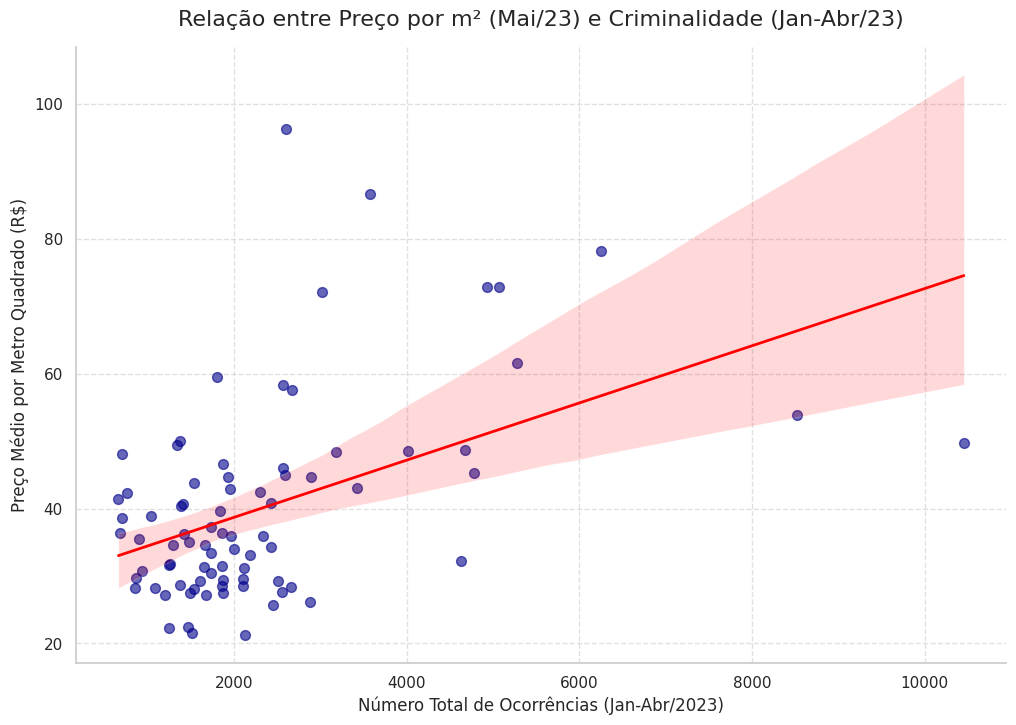


>>> Correlação (Preços Maio/23 vs. Crimes Jan-Abr/23): 0.47


<Figure size 1200x600 with 0 Axes>

In [38]:
# --- GRÁFICO DE CORRELAÇÃO (SNAPSHOT: Preço Maio/23 vs. Crimes Jan-Abr/23) ---

# 1. Plotar o Regplot
plt.figure(figsize=(12, 8))
sns.regplot(
    data=analise_final,
    # *** CORREÇÃO: Usar a nova coluna 'total_ocorrencias_jan_abr_2023' ***
    x='total_ocorrencias_jan_abr_2023',
    y='preco_m2_medio',
    scatter_kws={'alpha': 0.6, 's': 50, 'color': 'darkblue'},
    line_kws={'color': 'red', 'linewidth': 2}
)

# 2. Títulos e Eixos (Atualizados)
plt.title('Relação entre Preço por m² (Mai/23) e Criminalidade (Jan-Abr/23)', fontsize=16, pad=15)
plt.xlabel('Número Total de Ocorrências (Jan-Abr/2023)', fontsize=12)
plt.ylabel('Preço Médio por Metro Quadrado (R$)', fontsize=12)

# 3. Formatação
plt.grid(True, linestyle='--', alpha=0.6)
sns.despine()
plt.show()
plt.clf() # Limpa a figura

# 4. Calcular e imprimir a Correlação de Pearson
# *** CORREÇÃO: Usar a nova coluna 'total_ocorrencias_jan_abr_2023' ***
correlacao = analise_final['total_ocorrencias_jan_abr_2023'].corr(analise_final['preco_m2_medio'])
print(f"\n>>> Correlação (Preços Maio/23 vs. Crimes Jan-Abr/23): {correlacao:.2f}")

### Descoberta: O Paradoxo do Preço vs. Crime

O resultado foi **surpreendente e contrário à hipótese inicial**.

Ao compararmos os preços (o "Reflexo" de Maio/23) com os crimes que aconteceram antes (o "Espelho" do 1Quadri/23), encontramos uma correlação positiva de **+0,47.**

A linha vermelha de tendência no gráfico de dispersão, que mostra o padrão geral dos dados, está inclinada para cima.

**O que isso significa?**

>Ao contrário do que esperávamos, distritos com um "espelho" de crimes (Total de Ocorrências 1Quadri/2023 no Eixo X) mais alto, apresentam um "reflexo" de preço (Preço Médio m² de Maio/23 no Eixo Y) também mais alto.

O padrão é claro: **os locais mais caros são também os mais movimentados** e, consequentemente, os que registram mais crimes de oportunidade (furtos, roubos).

Distritos como Pinheiros e Jardins, por exemplo, concentram comércio, escritórios, vida noturna e um fluxo intenso de pessoas. Isso eleva o valor do metro quadrado, mas, ao mesmo tempo, aumenta as *oportunidades* para ocorrências.

Essa análise reforça a ideia de que a variável **“densidade econômica”** parece ser o fator oculto que explica por que bairros caros também aparecem como os mais violentos nos registros oficiais.

Isso nos leva a uma nova pergunta, que guiará o resto do projeto:

>**“Se o *volume total* de crimes não explica o preço, será que a *natureza* (tipo) do crime explica?”**


## 10) A Análise Definitiva: A Natureza do Crime

Na secção anterior, a nossa análise de "snapshot" (Jan-Abr/23 vs. Maio/23) mostrou que a densidade económica parece ser o fator oculto que explica o paradoxo (+0,47).

Isso nos forçou a questionar nossa premissa. A "métrica" está errada?

> **“Todos os tipos de crime afetam da mesma forma a percepção de segurança?”**

> **“Será que os crimes violentos têm mais impacto na escolha de um bairro do que os furtos e roubos?”**

Para testar isto, vamos:
1.  **Separar os crimes nas "cestas" (Violentos vs. Património)**.
O código abaixo irá filtrar o universo total de crimes (230 mil registros) e criar duas "cestas" focadas.
    * **Nota Metodológica Importante:** Nossas duas cestas (Violentos + Património) somam ~110 mil registros. Os ~120 mil registros "faltantes" são **intencionalmente removidos**. Eles são o "ruído": crimes culposos (não-intencionais) e de trânsito (ex: `"Homicídio Culposo por Acidente de Trânsito"` ou `"Lesão Corporal Culposa"`), que não afetam a *percepção de segurança* relevante para o aluguel.
2.  **Usar os dados trimestrais do `relatorioTri.xlsx`** (Bairros mais caros, valorizados, desvalorizados e procurados).
3.  **Cruzar os rankings trimestrais** com a média de crimes (Violentos vs. Património) de cada distrito.

In [39]:
# --- SEPARAÇÃO DE TIPOS DE CRIMES EM "CESTAS" ---
# OBJETIVO: Categorizar crimes para análises específicas.

# 1) Vamos primeiro ver todos os tipos de crime únicos que temos
lista_de_crimes = sorted(ocorrencias_long['tipo_delito'].unique())
print("--- Tipos de crime únicos no dataset: ---")
for crime in lista_de_crimes:
    print(f"- {crime}")

# 2) CESTA 1: Crimes Violentos (Ligados à percepção de segurança)
crimes_violentos_lista = [
    'HOMICÍDIO DOLOSO', 'LATROCÍNIO', 'ESTUPRO', 'ESTUPRO DE VULNERÁVEL',
    'LESÃO CORPORAL SEGUIDA DE MORTE', 'TENTATIVA DE HOMICÍDIO',
    'LESÃO CORPORAL DOLOSA', 'HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO'
]

# 3) CESTA 2: Crimes Contra o Patrimônio (Ligados à Oportunidade/Riqueza)
crimes_patrimonio_lista = [
    'ROUBO', 'FURTO', 'ROUBO DE VEÍCULO', 'FURTO DE VEÍCULO',
    'ROUBO A BANCO', 'ROUBO DE CARGA'
]

# 4) Filtra o dataframe 'ocorrencias_long' para cada cesta
ocorrencias_violentos = ocorrencias_long[
    ocorrencias_long['tipo_delito'].isin(crimes_violentos_lista)
]
ocorrencias_patrimonio = ocorrencias_long[
    ocorrencias_long['tipo_delito'].isin(crimes_patrimonio_lista)
]

print(f"\n--- Dataframes de crimes separados ---")
print(f"Total de registros em 'ocorrencias_long': {ocorrencias_long.shape[0]}")
print(f"Total de registros em 'ocorrencias_violentos': {ocorrencias_violentos.shape[0]}")
print(f"Total de registros em 'ocorrencias_patrimonio': {ocorrencias_patrimonio.shape[0]}")

print("\nAmostra de Crimes Violentos:")
display(ocorrencias_violentos.head())

--- Tipos de crime únicos no dataset: ---
- ESTUPRO
- ESTUPRO DE VULNERÁVEL
- FURTO - OUTROS
- FURTO DE VEÍCULO
- HOMICÍDIO CULPOSO OUTROS
- HOMICÍDIO CULPOSO POR ACIDENTE DE TRÂNSITO
- HOMICÍDIO DOLOSO (2)
- HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO
- LATROCÍNIO
- LESÃO CORPORAL CULPOSA - OUTRAS
- LESÃO CORPORAL CULPOSA POR ACIDENTE DE TRÂNSITO
- LESÃO CORPORAL DOLOSA
- LESÃO CORPORAL SEGUIDA DE MORTE
- Nº DE VÍTIMAS EM HOMICÍDIO DOLOSO (3)
- Nº DE VÍTIMAS EM HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO
- Nº DE VÍTIMAS EM LATROCÍNIO
- ROUBO - OUTROS
- ROUBO A BANCO
- ROUBO DE CARGA
- ROUBO DE VEÍCULO
- TENTATIVA DE HOMICÍDIO
- TOTAL DE ESTUPRO (4)
- TOTAL DE ROUBO - OUTROS (1)

--- Dataframes de crimes separados ---
Total de registros em 'ocorrencias_long': 230460
Total de registros em 'ocorrencias_violentos': 70140
Total de registros em 'ocorrencias_patrimonio': 40080

Amostra de Crimes Violentos:


,idOcorrenciaMensal,idDelito,idDistrito,ano,tipo_delito,id_tipo_delito,id_grupo_delito,mes,quantidade
2,0,72,1410,2019,HOMICÍDIO DOLOSO POR ACIDENTE DE TRÂNSITO,72,6,janeiro,0
6,0,42,1410,2019,TENTATIVA DE HOMICÍDIO,42,6,janeiro,2
7,0,130,1410,2019,LESÃO CORPORAL SEGUIDA DE MORTE,130,6,janeiro,0
8,0,24,1410,2019,LESÃO CORPORAL DOLOSA,24,6,janeiro,34
11,0,52,1410,2019,LATROCÍNIO,52,6,janeiro,0


### Descoberta (Dados Prontos)

Conseguimos! Agora temos dois dataframes de crimes: `ocorrencias_violentos` e `ocorrencias_patrimonio`.

Não podemos mais usar a "foto" de Maio/2023, pois ela mistura tudo. A verdadeira análise vem da comparação dos *rankings* de bairros ao longo do tempo.

Isso nos leva diretamente à próxima e mais importante pergunta:

>  **“Os bairros valorizados são realmente os mais seguros?”**

>  **“Ou será que existe um paradoxo: quanto mais caro, mais visado por furtos?”**

No próximo capítulo, vamos cruzar os rankings de bairros ("mais_caro", "valorizado", "desvalorizado") com essas duas novas tabelas de crimes. É lá que a história se completa.

## 11) A Descoberta Final (Segurança Pessoal vs. Patrimonial)

Chegamos ao ponto central. O paradoxo de "mais caro = mais crime" (correlação +0.48) nos fez suspeitar que a métrica "total de crimes" era o problema.

Agora, vamos testar a hipótese final:

> **“Os bairros valorizados são realmente os mais seguros?”**

> **“Ou será que existe um paradoxo: quanto mais caro, mais visado por furtos?”**

Para responder isso, o plano é:
1.  **Preparar os Rankings:** Pegar as planilhas de "Bairros mais caros", "valorizados" e "desvalorizados", limpá-las e descobrir a qual `id_distrito` cada bairro pertence. Faremos isso para todos os meses que temos dados.
2.  **Preparar os Crimes (Temporal):** Agregar nossas cestas de crimes (violentos/patrimônio) por `id_distrito`, `ano` e `mês`.
3.  **Unir e Analisar:** Cruzar os rankings de cada mês com os dados de crimes daquele mesmo mês e, enfim, calcular a **média de crimes** para cada categoria de ranking ("mais_caro", "valorizado", "desvalorizado").

In [40]:
# --- PASSO 1: PREPARAR OS RANKINGS TRIMESTRAIS (Corrigido) ---
# OBJETIVO: Carregar os rankings do relatorioTri, limpar e adicionar id_distrito.

print("--- 1. Preparando Rankings Trimestrais (do relatorioTri.xlsx) ---")

# 1a) Criar a "ponte" Bairro -> id_distrito (da Célula 14)
bairros_ponte_df = distritos_bairros['Bairro'].copy()
# Limpa os nomes dos bairros na "ponte" para o merge
bairros_ponte_df['bairro_limpo'] = (
    bairros_ponte_df['Bairro'].astype(str)
    .apply(lambda x: re.sub(r"\\(.*?\\)", "", x).strip())
    .apply(unidecode.unidecode)
    .str.lower()
)
bairros_ponte_df = bairros_ponte_df[['bairro_limpo', 'id_distrito']].drop_duplicates()
print("Ponte Bairro -> id_distrito criada.")

# 1b) Função para limpar e unificar os 4 dataframes de ranking
def preparar_ranking(df_bruto, tipo_ranking):
    df = df_bruto.copy()
    # Renomear colunas inconsistentes (ex: 'bairro' vs 'Bairro', 'ano ' vs 'Ano', 'trimestre' vs 'Trimestre')
    df.columns = [col.strip().lower() for col in df.columns]
    df = df.rename(columns={'trimestre': 'trimestre_num'})

    # Limpar nomes dos bairros
    df['bairro_limpo'] = (
        df['bairro'].astype(str)
        .apply(lambda x: re.sub(r"\\(.*?\\)", "", x).strip())
        .apply(unidecode.unidecode)
        .str.lower()
    )

    # Adicionar o id_distrito usando a "ponte"
    df_merged = pd.merge(df, bairros_ponte_df, on='bairro_limpo', how='left')

    # Adicionar o tipo de ranking
    df_merged['tipo_ranking'] = tipo_ranking

    # Manter apenas colunas úteis e remover nulos
    colunas_finais = ['ano', 'trimestre_num', 'bairro', 'id_distrito', 'tipo_ranking']
    df_final = df_merged[colunas_finais].dropna(subset=['id_distrito', 'ano', 'trimestre_num'])

    return df_final

# 1c) Carregar e preparar cada aba de ranking (do relatorioTri)
try:
    df_caros = preparar_ranking(relatorioTri['Bairros mais caros'], 'mais_caro')
    df_valorizados = preparar_ranking(relatorioTri['Bairros mais valorizados'], 'valorizado')
    df_desvalorizados = preparar_ranking(relatorioTri['Bairros mais desvalorizados'], 'desvalorizado')
    df_procurados = preparar_ranking(relatorioTri['Bairros mais procurados'], 'mais_procurado')

    # 1d) Juntar todos em um único dataframe
    rankings_final_com_distrito = pd.concat([df_caros, df_valorizados, df_desvalorizados, df_procurados], ignore_index=True)

    # Converter tipos
    rankings_final_com_distrito['ano'] = rankings_final_com_distrito['ano'].astype(int)
    rankings_final_com_distrito['trimestre_num'] = rankings_final_com_distrito['trimestre_num'].astype(int)
    rankings_final_com_distrito['id_distrito'] = rankings_final_com_distrito['id_distrito'].astype(int)

    print(f"\n--- Rankings Trimestrais preparados e com id_distrito ---")
    print(f"Total de {rankings_final_com_distrito.shape[0]} registros de ranking prontos para análise.")
    print("Tipos de ranking encontrados:")
    print(rankings_final_com_distrito['tipo_ranking'].unique())
    display(rankings_final_com_distrito.head())

except KeyError as e:
    print(f"\nERRO: A aba {e} não foi encontrada no 'relatoriosTrimestrais.xlsx'.")
except Exception as e:
    print(f"Um erro inesperado ocorreu: {e}")

--- 1. Preparando Rankings Trimestrais (do relatorioTri.xlsx) ---
Ponte Bairro -> id_distrito criada.

--- Rankings Trimestrais preparados e com id_distrito ---
Total de 294 registros de ranking prontos para análise.
Tipos de ranking encontrados:
['mais_caro' 'valorizado' 'desvalorizado' 'mais_procurado']


,ano,trimestre_num,bairro,id_distrito,tipo_ranking
0,2025,1,Vila Nova Conceição,1256,mais_caro
1,2025,1,Sumaré,1151,mais_caro
2,2025,1,Pinheiros,1257,mais_caro
3,2025,1,Jardim Paulista,937,mais_caro
4,2025,1,Itaim Bibi,1256,mais_caro


--- 2. Preparando Crimes (Agrupamento Trimestral) ---
Mapeamento de mês para trimestre concluído.
Tabelas de crimes agregadas por Trimestre/Distrito.

--- 3. Unindo Rankings Trimestrais e Crimes Trimestrais ---

--- MÉDIA DE CRIMES VIOLENTOS POR TIPO DE RANKING ---
tipo_ranking
desvalorizado     91.56
mais_caro         84.34
mais_procurado    91.16
valorizado        90.80
Name: total_ocorrencias_violentos, dtype: float64

--- MÉDIA DE CRIMES CONTRA O PATRIMÔNIO POR TIPO DE RANKING ---
tipo_ranking
desvalorizado     152.22
mais_caro         156.04
mais_procurado    208.94
valorizado        177.25
Name: total_ocorrencias_patrimonio, dtype: float64


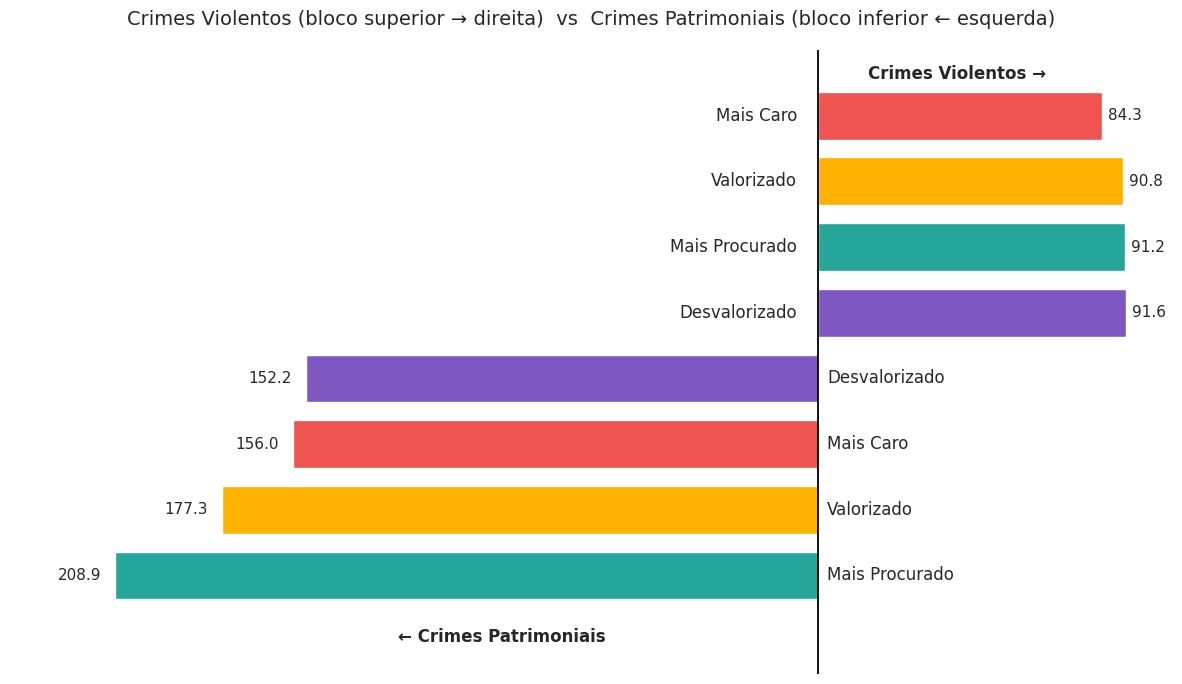

<Figure size 1200x600 with 0 Axes>

In [41]:
# --- PASSO 2: PREPARAR OS CRIMES (TEMPORAL TRIMESTRAL) ---
# OBJETIVO: Agregar as "cestas" de crimes por distrito, ano e TRIMESTRE.
# (Este bloco é necessário para gerar as variáveis do gráfico)

print("--- 2. Preparando Crimes (Agrupamento Trimestral) ---")

# 2a) Adiciona 'mes_num' aos dataframes de cestas
mapa_meses_num = {
    'janeiro': 1, 'fevereiro': 2, 'marco': 3, 'abril': 4, 'maio': 5, 'junho': 6,
    'julho': 7, 'agosto': 8, 'setembro': 9, 'outubro': 10, 'novembro': 11, 'dezembro': 12
}

# Garante que as sub-tabelas tenham o 'mes_num'
# (Usamos .copy() para evitar o SettingWithCopyWarning)
ocorrencias_violentos = ocorrencias_violentos.copy()
ocorrencias_patrimonio = ocorrencias_patrimonio.copy()
ocorrencias_violentos['mes_num'] = ocorrencias_violentos['mes'].map(mapa_meses_num)
ocorrencias_patrimonio['mes_num'] = ocorrencias_patrimonio['mes'].map(mapa_meses_num)

# 2b) Mapeia o mês para trimestre_num (1, 2, 3, 4)
ocorrencias_violentos['trimestre_num'] = ((ocorrencias_violentos['mes_num'] - 1) // 3) + 1
ocorrencias_patrimonio['trimestre_num'] = ((ocorrencias_patrimonio['mes_num'] - 1) // 3) + 1
print("Mapeamento de mês para trimestre concluído.")

# 2c) Cria as tabelas temporais agregadas por TRIMESTRE
crimes_violentos_trimestral = (
    ocorrencias_violentos.groupby(['idDistrito', 'ano', 'trimestre_num'])['quantidade']
    .sum().reset_index()
    .rename(columns={'idDistrito': 'id_distrito', 'quantidade': 'total_ocorrencias_violentos'})
)

crimes_patrimonio_trimestral = (
    ocorrencias_patrimonio.groupby(['idDistrito', 'ano', 'trimestre_num'])['quantidade']
    .sum().reset_index()
    .rename(columns={'idDistrito': 'id_distrito', 'quantidade': 'total_ocorrencias_patrimonio'})
)
print("Tabelas de crimes agregadas por Trimestre/Distrito.")

# --- PASSO 3: UNIR E ANALISAR
print("\n--- 3. Unindo Rankings Trimestrais e Crimes Trimestrais ---")

# 3a) JUNÇÃO 1: Rankings vs. Crimes VIOLENTOS (ambos trimestrais)
analise_violentos = pd.merge(
    rankings_final_com_distrito,
    crimes_violentos_trimestral,
    on=['id_distrito', 'ano', 'trimestre_num'],
    how='left'
)
analise_violentos.dropna(subset=['total_ocorrencias_violentos'], inplace=True)

# 3b) JUNÇÃO 2: Rankings vs. Crimes CONTRA O PATRIMÔNIO (ambos trimestrais)
analise_patrimonio = pd.merge(
    rankings_final_com_distrito,
    crimes_patrimonio_trimestral,
    on=['id_distrito', 'ano', 'trimestre_num'],
    how='left'
)
analise_patrimonio.dropna(subset=['total_ocorrencias_patrimonio'], inplace=True)

# 3c) A ANÁLISE: Calcular a média de crimes por tipo de ranking
# Estas são as variáveis que o gráfico usará:
media_violentos_por_ranking = analise_violentos.groupby('tipo_ranking')['total_ocorrencias_violentos'].mean()
media_patrimonio_por_ranking = analise_patrimonio.groupby('tipo_ranking')['total_ocorrencias_patrimonio'].mean()

print("\n--- MÉDIA DE CRIMES VIOLENTOS POR TIPO DE RANKING ---")
print(media_violentos_por_ranking.round(2))
print("\n--- MÉDIA DE CRIMES CONTRA O PATRIMÔNIO POR TIPO DE RANKING ---")
print(media_patrimonio_por_ranking.round(2))

violentos_series = media_violentos_por_ranking
patrimonio_series = media_patrimonio_por_ranking

# ---------- ORDENAR (Dinamicamente, a partir das Series) ----------
vio_labels = violentos_series.sort_values(ascending=False).index
pat_labels = patrimonio_series.sort_values(ascending=False).index

vio_values = violentos_series.sort_values(ascending=False).values
pat_values = patrimonio_series.sort_values(ascending=False).values

# ---------- POSIÇÕES (coladas, sem espaço entre blocos) ----------
gap = 1.1
y_top = np.arange(len(vio_labels)) * gap + len(pat_labels) * gap   # bloco superior
y_bottom = np.arange(len(pat_labels)) * gap                      # bloco inferior

# ---------- CORES (4 categorias = 4 cores) ----------
cores = {
    "desvalorizado": "#7E57C2",   # Roxo
    "mais_procurado": "#26A69A",  # Verde água
    "valorizado": "#FFB300",      # Amarelo
    "mais_caro": "#EF5350"        # Vermelho
}

# ---------- FIGURA ----------
fig, ax = plt.subplots(figsize=(12, 7))
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

# ---------- LINHA CENTRAL ----------
ax.axvline(0, color='black', linewidth=1.3)

# -------------------- BARRAS VIOLENTOS (direita, bloco superior) --------------------
for yi, lab, val in zip(y_top, vio_labels, vio_values):
    ax.barh(yi, val, color=cores[lab], height=0.8)
    ax.text(val + max(vio_values)*0.02, yi, f"{val:.1f}", va='center', ha='left', fontsize=11)

# -------------------- BARRAS PATRIMONIAIS (esquerda, bloco inferior) --------------------
for yi, lab, val in zip(y_bottom, pat_labels, pat_values):
    ax.barh(yi, -val, color=cores[lab], height=0.8)
    ax.text(-val - max(pat_values)*0.02, yi, f"{val:.1f}", va='center', ha='right', fontsize=11)

# -------------------- LABELS DAS CATEGORIAS --------------------
# (Os labels são posicionados nos lados opostos das barras para clareza)
for yi, lab in zip(y_top, vio_labels):
    ax.text(-max(pat_values)*0.03, yi, lab.replace("_"," ").title(), va='center', ha='right', fontsize=12)

for yi, lab in zip(y_bottom, pat_labels):
    ax.text(max(vio_values)*0.03, yi, lab.replace("_"," ").title(), va='center', ha='left', fontsize=12)

# ---------- TÍTULO E RÓTULOS LATERAIS (EXPLICANDO CADA LADO) ----------
ax.set_title("Crimes Violentos (bloco superior → direita)  vs  Crimes Patrimoniais (bloco inferior ← esquerda)",
             fontsize=14, pad=18)
# rótulos explicativos próximos ao topo, alinhados com cada bloco
ax.text(max(vio_values)*0.45, y_top.max() + gap*0.5, "Crimes Violentos →", ha='center', va='bottom', fontsize=12, fontweight='bold')
ax.text(-max(pat_values)*0.45, -gap*0.8, "← Crimes Patrimoniais", ha='center', va='top', fontsize=12, fontweight='bold')

# ---------- ESTILO LIMPO ----------
ax.set_yticks([])
ax.set_xticks([])

for spine in ax.spines.values():
    spine.set_visible(False)

# Limites laterais para dar espaço aos rótulos/valores
ax.set_xlim(-max(pat_values)*1.15, max(vio_values)*1.15)
ax.set_ylim(-gap*1.5, y_top.max() + gap*1.0)

plt.tight_layout()
plt.savefig("bilateral_ranking_tradeoff.png", bbox_inches='tight')
plt.show()
plt.clf()

# A Descoberta Final: Expectativa (Mercado) vs. Realidade (Dados)

Nossa pergunta inicial era: "A segurança (ou a falta dela) afeta o preço dos imóveis?". O paradoxo que encontramos (correlação +0.47) nos mostrou que a relação não era simples.

 Este gráfico bilateral finalmente resolve a questão. Mas, para entendê-lo, precisamos primeiro definir a "**Expectativa**" do mercado, com base nas próprias definições do QuintoAndar que pesquisamos:

*   A **"Expectativa" para "Valorizado":** O mercado define esta categoria como
tendo **"Qualidade de vida e segurança: Áreas com boa segurança pública."**

*    A **"Expectativa" para "Desvalorizado":** O mercado define esta categoria como tendo **"Problemas de segurança: Alta incidência de criminalidade..."**

Agora, vamos confrontar essa "Expectativa" com a "**Realidade**" (nosso gráfico, que cruza os rankings do QuintoAndar com os dados da SSP):

## Análise da "Realidade":

O gráfico é dividido em dois blocos, que são a "Realidade" dos dados:

*   **Bloco Superior** (Direita): Média de Crimes **Violentos** (Segurança Pessoal).

*   **Bloco Inferior** (Esquerda): Média de Crimes Contra o **Patrimônio** (Alvo de Riqueza).

## Descoberta 1: A "Expectativa" vs. "Realidade" da Violência (Bloco Direito)

A "Expectativa" é **confirmada** para `Desvalorizado`: Como o mercado espera, a categoria Desvalorizado (**91.6**) de fato lidera como a mais perigosa em termos de Crimes Violentos.

A "Expectativa" é **refutada** para `Valorizado`: Aqui está a grande descoberta. O mercado espera "boa segurança", mas a realidade dos dados mostra que Valorizado (**90.8**) tem a terceira pior média de violência, quase empatada com a "Desvalorizado".

A "Realidade" Oculta: A única categoria estatisticamente segura (com a menor média de violência) é a `Mais Caro` (**84.3**).

##Descoberta 2: O Paradoxo do Patrimônio (Bloco Esquerdo)

A história se inverte para Crimes Patrimoniais. As categorias de desejo e crescimento — `Mais Procurado` (**208.9**) e `Valorizado` (**177.2**) — são os maiores alvos de roubos e furtos.

O `Desvalorizado` (**152.2**), por ter menor atividade econômica e ser menos desejado, é o menos visado por crimes de patrimônio.

##O "Trade-off" (A Troca)

Isso revela o "trade-off" (a troca) que o mercado faz: O mercado paga mais (`Mais Caro`) por *segurança pessoal* (menos violência), e está disposto a aceitar um risco maior de *segurança patrimonial* (mais roubos) como um "custo" de se morar em uma área de desejo (`Mais Procurado`).

##Nota Metodológica (Por que usamos a Média e não a Soma?)

Esta foi uma decisão metodológica crucial. (Como você mesma brilhantemente explicou):

1.   A Estrutura: Cada categoria (ex: "valorizado") é um grupo que contém vários distritos que apareceram nos rankings ao longo de vários trimestres.

2.   O Problema da Soma: Se apenas somássemos (sum()) todos os crimes de cada categoria, teríamos um resultado enganoso. Uma categoria com mais registros (ex: "valorizado" apareceu 100 vezes) pareceria ter "mais crimes" do que uma categoria com menos registros (ex: "mais_caro" apareceu 50 vezes), simplesmente por ter mais dados. Não seria um indicador real de segurança.

3.   A Solução (Média): Ao usar a média (mean()), normalizamos a comparação. O resultado (ex: 91.6) não é a soma total, mas sim a média de crimes trimestral típica de um distrito quando ele está naquela categoria. Isso nos permite comparar "maçãs com maçãs" (o nível de segurança típico de cada perfil) de forma justa.

# 12) O Contexto da Cidade (Análise Macro Mensal)

Resolvemos o paradoxo em nível de distrito, provando que a natureza do crime importa. A descoberta foi:

Crimes Violentos (Segurança Pessoal) afastam o valor (ex: "Desvalorizado").

Crimes de Patrimônio (Alvo de Riqueza) são um "custo" aceito em áreas de desejo (ex: "Mais Procurado").

>**Mas será que essa lógica se aplica à cidade inteira? O preço médio de São Paulo (influenciado pela economia) sobe e desce acompanhando os Crimes de Patrimônio?**

Para responder a isso, vamos cruzar duas séries temporais mensais:

Preço (R$/m²): A média de anúncios em São Paulo (da aba Dados Gerais do quintoAndar.xlsx).

Crimes: O volume total de Crimes contra o Patrimônio (soma da nossa "cesta" de patrimônio por mês).

--- Passo 1: Preparando os Dados de Preço Macro (Mensal R$/m²) ---
 Tabela de Preços Macro (Mensal) pronta!


,ano,mes_num,preco_medio_sp
27,2025,4,68.83
28,2025,5,68.91
29,2025,6,68.90
30,2025,7,68.98
31,2025,8,69.14



--- Passo 2: Preparando os Dados de Crime Macro (Mensal - Patrimônio) ---
 Tabela de Crimes de Patrimônio Macro (Mensal) pronta!


,ano,mes_num,total_ocorrencias_patrimonio_sp
79,2025,8,0
80,2025,9,0
81,2025,10,0
82,2025,11,0
83,2025,12,0



--- Passo 3: Junção Final e Filtro Temporal ---
 Tabela Macro Final (Mensal) pronta e FILTRADA! 25 meses.


,ano,mes_num,preco_medio_sp,total_ocorrencias_patrimonio_sp,ano_mes_label
5,2023,7,58.61,4762,2023-07
6,2023,8,58.73,4984,2023-08
7,2023,9,58.94,4647,2023-09
8,2023,10,59.18,5061,2023-10
9,2023,11,59.39,5176,2023-11



--- Gerando Gráfico Macro (Eixo Duplo) ---


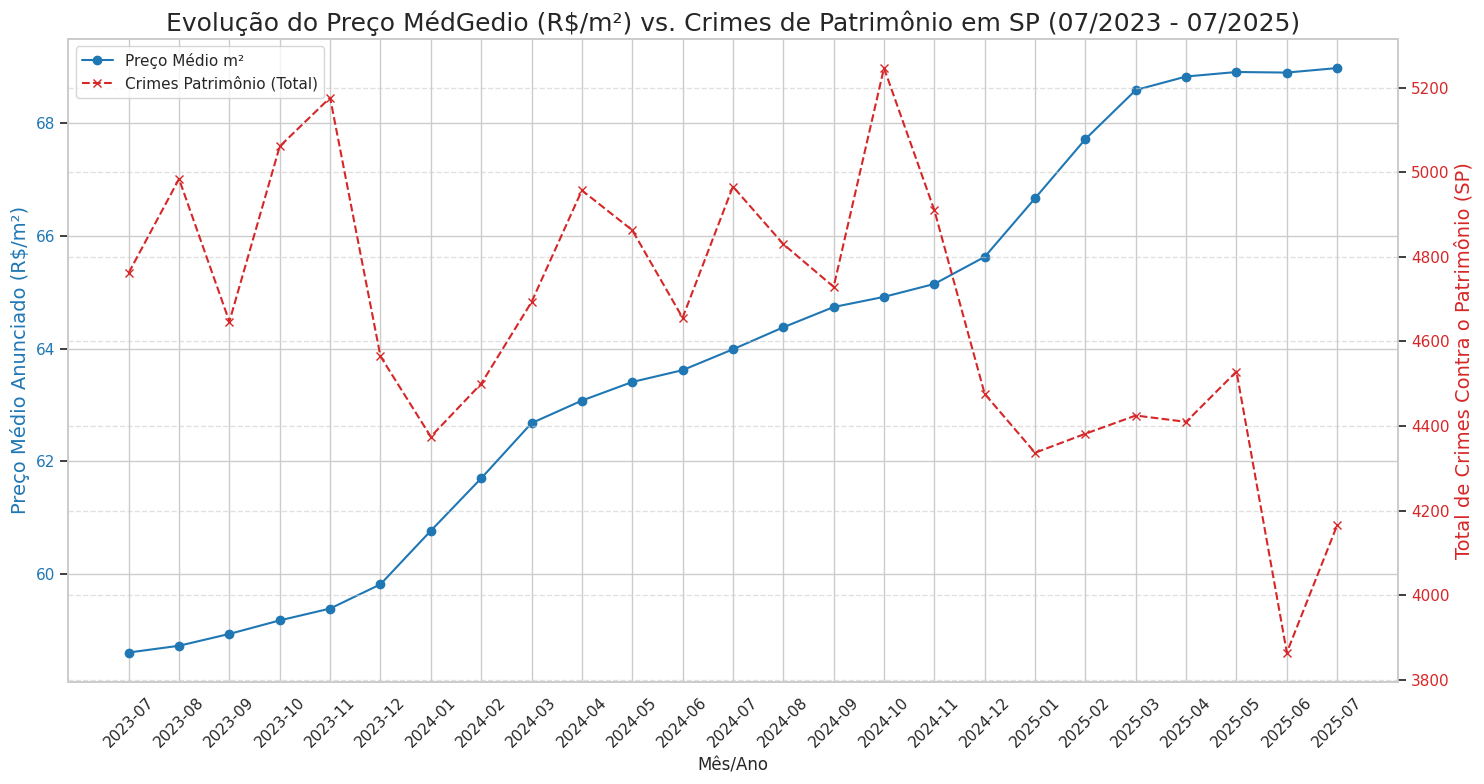


Gráfico 'macro_mensal_preco_vs_patrimonio.png' salvo e exibido.


<Figure size 1200x600 with 0 Axes>

In [42]:
# --- ANÁLISE MACRO MENSAL: PREÇO MÉDIO SP vs CRIMES DE PATRIMÔNIO ---
# OBJETIVO: Construir séries macro (SP inteiro) de preço e crimes de patrimônio por MÊS.

print("--- Passo 1: Preparando os Dados de Preço Macro (Mensal R$/m²) ---")
# 1a) Carregar dados da aba correta (quintoAndar)
try:
    precos_macro_df = quintoAndar['Dados Gerais'].copy()
    precos_macro_df.rename(columns={'Preço Médio do m² (R$)': 'preco_medio_sp'}, inplace=True)

    # 1b) Limpar e extrair Ano e Mês da coluna 'Mês/Ano' (ex: "2023-01-01")
    precos_macro_df['Mês/Ano'] = pd.to_datetime(precos_macro_df['Mês/Ano'], errors='coerce')
    precos_macro_df['ano'] = precos_macro_df['Mês/Ano'].dt.year
    precos_macro_df['mes_num'] = precos_macro_df['Mês/Ano'].dt.month

    # 1c) Limpar preço
    precos_macro_df['preco_medio_sp'] = pd.to_numeric(precos_macro_df['preco_medio_sp'], errors='coerce')
    precos_macro_df = precos_macro_df.dropna(subset=['preco_medio_sp', 'ano', 'mes_num'])

    precos_macro_df = precos_macro_df[['ano', 'mes_num', 'preco_medio_sp']].drop_duplicates()
    print(" Tabela de Preços Macro (Mensal) pronta!")
    display(precos_macro_df.tail())

except KeyError:
    print("ERRO: Aba 'Dados Gerais' não encontrada no quintoAndar.xlsx.")
except Exception as e:
    print(f"Erro ao processar Preços Macro: {e}")


print("\n--- Passo 2: Preparando os Dados de Crime Macro (Mensal - Patrimônio) ---")
# (Usando o 'ocorrencias_patrimonio' da Célula 28 e 'mapa_meses_num' da Célula 30)
try:
    # 2a) Mapeia o mês para mes_num (já deve estar feito na Célula 30, mas garantimos aqui)
    if 'mes_num' not in ocorrencias_patrimonio.columns:
         mapa_meses_num = {
            'janeiro': 1, 'fevereiro': 2, 'marco': 3, 'abril': 4, 'maio': 5, 'junho': 6,
            'julho': 7, 'agosto': 8, 'setembro': 9, 'outubro': 10, 'novembro': 11, 'dezembro': 12
         }
         ocorrencias_patrimonio['mes_num'] = ocorrencias_patrimonio['mes'].map(mapa_meses_num)

    # 2b) Agrupa o TOTAL de crimes de PATRIMÔNIO (soma da cesta) por MÊS
    crimes_macro_df = (
        ocorrencias_patrimonio.groupby(['ano', 'mes_num'])['quantidade']
        .sum().reset_index()
        .rename(columns={'quantidade': 'total_ocorrencias_patrimonio_sp'})
    )
    print(" Tabela de Crimes de Patrimônio Macro (Mensal) pronta!")
    display(crimes_macro_df.tail())

except Exception as e:
    print(f"Erro ao processar Crimes Macro: {e}")


print("\n--- Passo 3: Junção Final e Filtro Temporal ---")
analise_macro_final = pd.merge(precos_macro_df, crimes_macro_df, on=['ano', 'mes_num'], how='inner')

# Criar uma coluna de label (ex: "2023-01") para o gráfico
analise_macro_final['ano_mes_label'] = analise_macro_final['ano'].astype(str) + '-' + analise_macro_final['mes_num'].astype(str).str.zfill(2)

# --- INÍCIO DA CORREÇÃO: Aplicando o filtro temporal ---
# Filtra para o período de 07/2023 até 07/2025
analise_macro_final = analise_macro_final[
    (analise_macro_final['ano_mes_label'] >= '2023-07') &
    (analise_macro_final['ano_mes_label'] <= '2025-07')
].copy()
# --- FIM DA CORREÇÃO ---

analise_macro_final = analise_macro_final.sort_values(by=['ano', 'mes_num'])
print(f" Tabela Macro Final (Mensal) pronta e FILTRADA! {analise_macro_final.shape[0]} meses.")
display(analise_macro_final.head())


# --- O GRÁFICO FINAL (MACRO MENSAL) ---
print("\n--- Gerando Gráfico Macro (Eixo Duplo) ---")
fig, ax1 = plt.subplots(figsize=(15, 8))

# Eixo Esquerdo (Preço)
color = 'tab:blue'
ax1.set_xlabel('Mês/Ano', fontsize=12)
ax1.set_ylabel('Preço Médio Anunciado (R$/m²)', color=color, fontsize=14)
ax1.plot(analise_macro_final['ano_mes_label'], analise_macro_final['preco_medio_sp'], color=color, marker='o', label='Preço Médio m²')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=45) # Rotação para datas

# Eixo Direito (Crimes de Patrimônio)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total de Crimes Contra o Patrimônio (SP)', color=color, fontsize=14)
ax2.plot(analise_macro_final['ano_mes_label'], analise_macro_final['total_ocorrencias_patrimonio_sp'], color=color, marker='x', linestyle='--', label='Crimes Patrimônio (Total)')
ax2.tick_params(axis='y', labelcolor=color)

# Título (Atualizado para refletir o filtro)
plt.title('Evolução do Preço MédGedio (R$/m²) vs. Crimes de Patrimônio em SP (07/2023 - 07/2025)', fontsize=18)
fig.tight_layout()

# Legenda combinada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("macro_mensal_preco_vs_patrimonio.png", bbox_inches='tight')
plt.show()
plt.clf()

print("\nGráfico 'macro_mensal_preco_vs_patrimonio.png' salvo e exibido.")

### Descoberta (Visão Macro)

O gráfico de linhas duplas é claro: as duas linhas estão **desacopladas**.

A linha azul (Preço Médio) mostra uma tendência de **forte valorização** ao longo do período.
A linha vermelha (Crimes) **flutua** em um patamar elevado, mas não demonstra uma correlação inversa com os preços. Os preços subiram *apesar* da criminalidade.

Isso reforça nossa conclusão: os dados não parecem se relacionar porque a análise Macro (a cidade inteira) é "barulhenta" demais. Ela mistura o "Valorizado" com o "Desvalorizado", o "Mais Caro" com o "Mais Barato", e o sinal se perde no ruído.

Então abordamos uma nova estratégia de análise.

# 13) A Análise Zonal (Preço Zonal vs. Crime Zonal)

Até agora, provamos duas coisas:

A análise Macro (cidade inteira) é inconclusiva, pois o "ruído" esconde os padrões.

A análise por Categoria (abstrata) provou que o mercado se importa mais com Crimes Violentos do que com Crimes de Patrimônio.

Mas será que isso é verdade para a cidade inteira? Ou será que a zona rica "puxou" a média para cima, escondendo a realidade das outras zonas?

> **“Esses padrões se confirmam visualmente, ou os dados se comportam de maneira mais complexa?”**

Para responder, vamos "dar zoom" em cada uma das 5 grandes zonas (Centro, Leste, Norte, Oeste, Sul), cruzando a **Os valores de R$/m² por zona, trimestrais** (dos relatórios trimestrais) com os **Crimes de Patrimônio por Zona e por Trimestre** e depois com os **Crimes Violentos por Zona e por Trimestre**.

--- 1. Preparando Dados de Preço (Zonal Trimestral) ---
Combinando 'Leste I' e 'Leste II' para 'leste' (Preços)...
 Tabela de Preços Zonais (Trimestral) pronta!

--- 2. Preparando Dados de Crime (Zonal Trimestral) ---
 Tabela de Crimes de Patrimônio Zonais (Trimestral) pronta!


,ano,trimestre_num,zona,total_ocorrencias_patrimonio_zonal
0,2019,1,centro,658
1,2019,1,centro oeste,1042
2,2019,1,centro sul,627
3,2019,1,leste,1862
4,2019,1,norte,999



--- Passo 3: Junção Final (Zonal) ---
 Tabela Zonal Final (Trimestral) pronta! 70 registros.


,ano,trimestre_num,zona,preco_m2_zonal,zona_lower,zona_y,total_ocorrencias_patrimonio_zonal,trimestre_label
0,2023,1,Centro,7042.9,centro,centro,746,2023-T1
7,2023,2,Centro,6875.0,centro,centro,742,2023-T2
14,2023,3,Centro,6750.0,centro,centro,705,2023-T3
21,2023,4,Centro,6854.5,centro,centro,750,2023-T4
28,2024,1,Centro,7692.3,centro,centro,657,2024-T1



--- Gerando 7 Gráficos Zonais (Preço vs. Crime) ---

--- Gráfico para: CENTRO ---


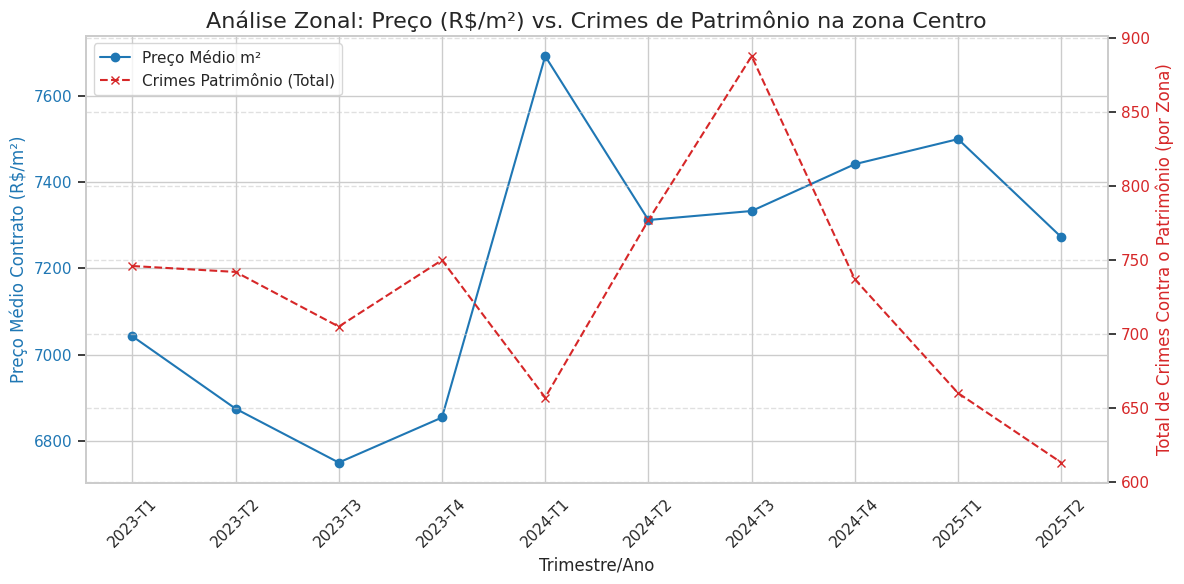


--- Gráfico para: CENTRO OESTE ---


<Figure size 1200x600 with 0 Axes>

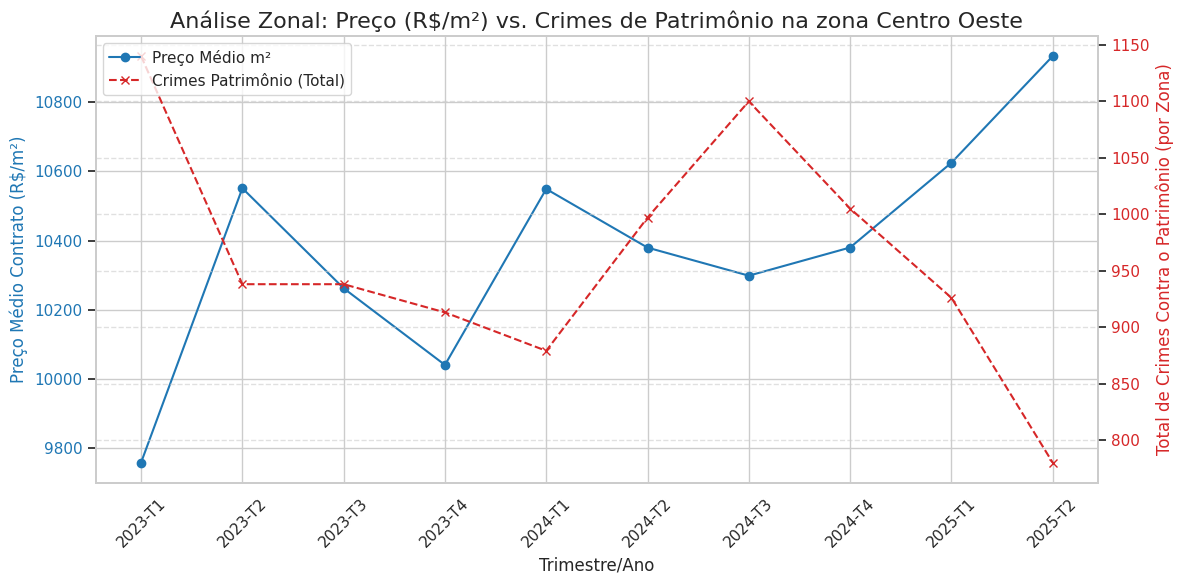


--- Gráfico para: CENTRO SUL ---


<Figure size 1200x600 with 0 Axes>

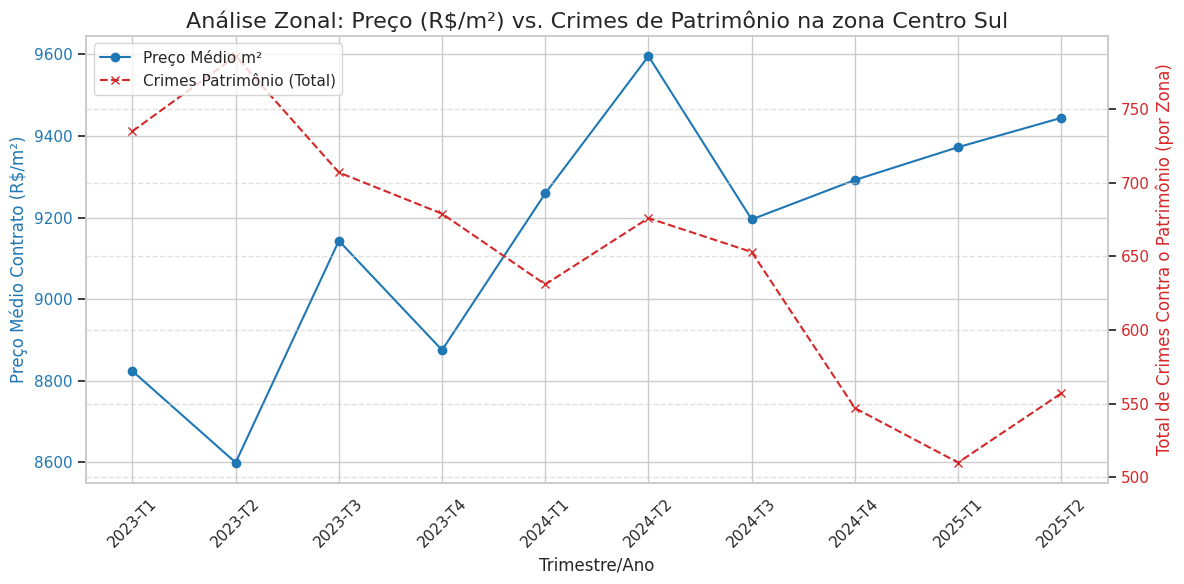


--- Gráfico para: LESTE ---


<Figure size 1200x600 with 0 Axes>

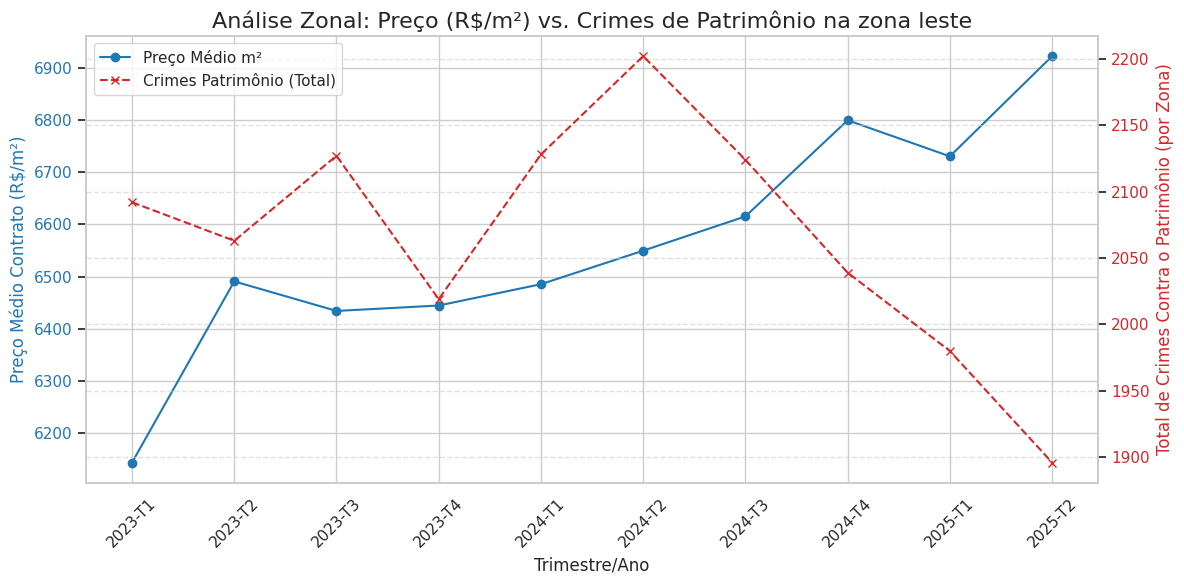


--- Gráfico para: NORTE ---


<Figure size 1200x600 with 0 Axes>

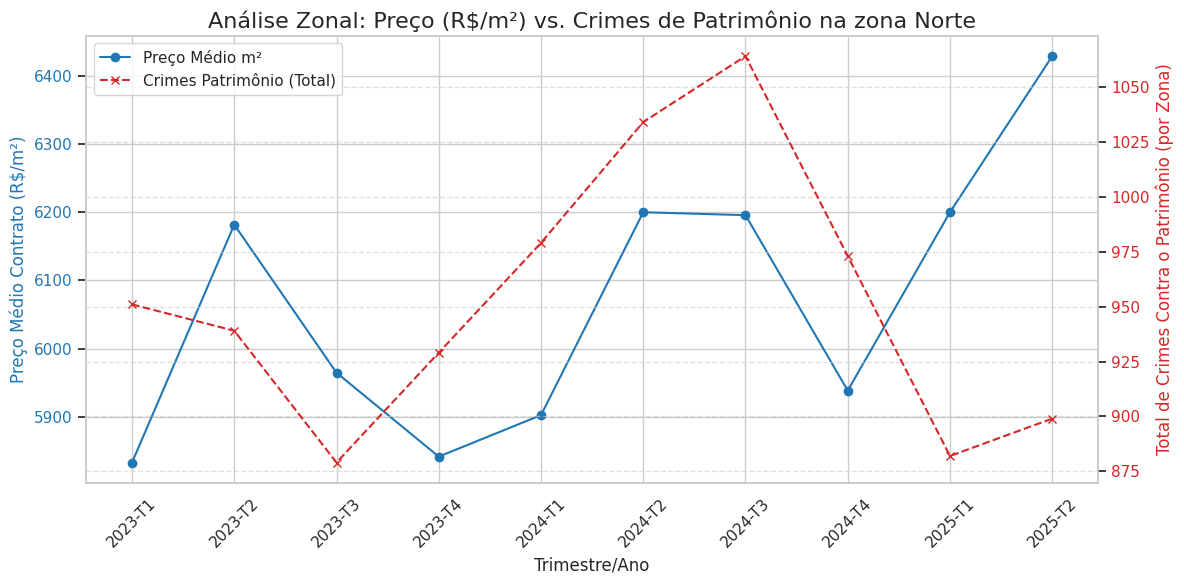


--- Gráfico para: OESTE ---


<Figure size 1200x600 with 0 Axes>

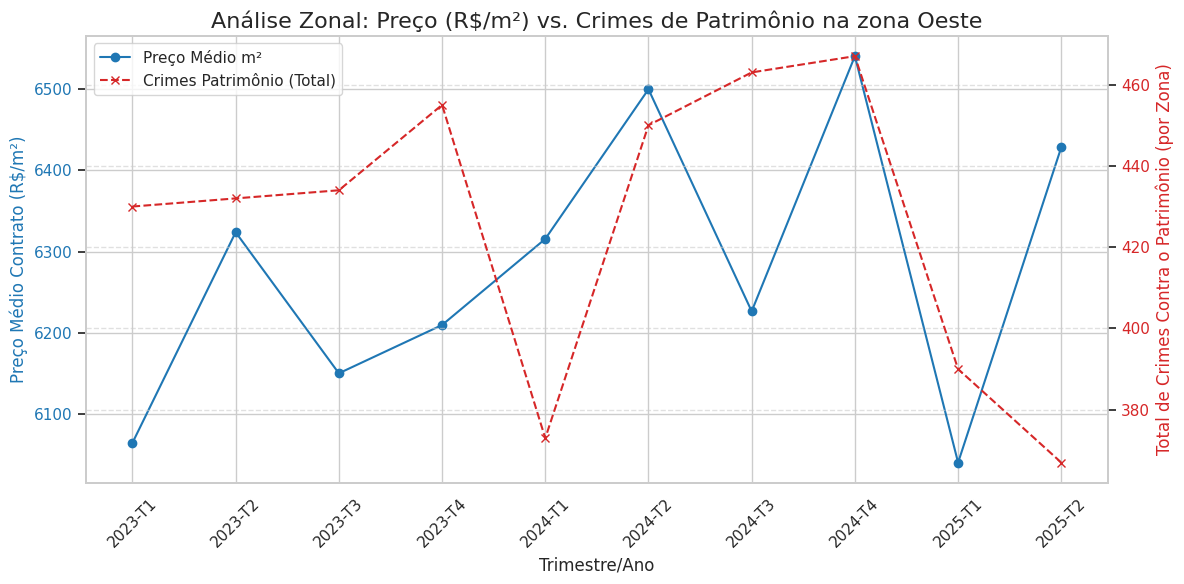


--- Gráfico para: SUL ---


<Figure size 1200x600 with 0 Axes>

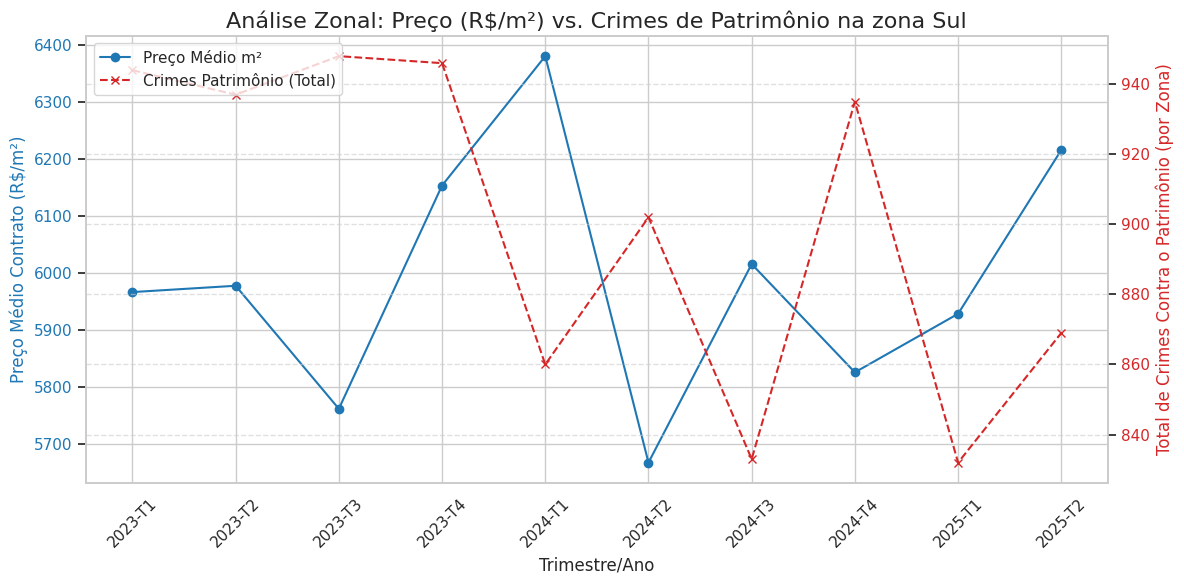


Gráficos zonais salvos e exibidos.


<Figure size 1200x600 with 0 Axes>

In [43]:
# --- ANÁLISE TEMPORAL ZONAL (PREÇO ZONAL vs. CRIME ZONAL) ---
# OBJETIVO: Plotar a evolução do Preço R$/m² vs. Crimes de Patrimônio
#           em gráficos separados para cada Zona.

print("--- 1. Preparando Dados de Preço (Zonal Trimestral) ---")
# 1a) Carregar dados da aba correta (relatorioTri)
try:
    # Assumindo que a aba com os R$/m² por zona se chama 'Valores por zona'
    # Se o nome for outro (ex: 'Preço por zona'), ajuste a string abaixo.
    precos_zonal_df = relatorioTri['Valores por zona'].copy()

    # 1b) Limpar e renomear colunas
    precos_zonal_df.columns = [col.strip().lower() for col in precos_zonal_df.columns]
    precos_zonal_df = precos_zonal_df.rename(columns={
        'região': 'zona',
        'valor': 'preco_m2_zonal',
        'trimestre': 'trimestre_num'
    })

    # 1c) Limpar preço e tipos de dados
    precos_zonal_df['preco_m2_zonal'] = pd.to_numeric(precos_zonal_df['preco_m2_zonal'], errors='coerce')
    precos_zonal_df = precos_zonal_df.dropna(subset=['preco_m2_zonal', 'ano', 'trimestre_num'])

    # --- INÍCIO DA CORREÇÃO: Combinando 'Leste I' e 'Leste II' nos Preços ---
    print("Combinando 'Leste I' e 'Leste II' para 'leste' (Preços)...")
    # 1d) Mapeia 'Leste I' e 'Leste II' para 'leste'
    #     (case=False lida com "Leste I" ou "leste i")
    precos_zonal_df['zona'] = precos_zonal_df['zona'].str.replace('leste i', 'leste', case=False).str.replace('leste ii', 'leste', case=False)

    # 1e) Agrupa por 'leste' e calcula a MÉDIA dos preços
    precos_zonal_df = (
        precos_zonal_df.groupby(['ano', 'trimestre_num', 'zona'])['preco_m2_zonal']
        .mean() # Usamos a média para o R$/m²
        .reset_index()
    )
    # --- FIM DA CORREÇÃO ---

    precos_zonal_df = precos_zonal_df[['ano', 'trimestre_num', 'zona', 'preco_m2_zonal']].drop_duplicates()
    print(" Tabela de Preços Zonais (Trimestral) pronta!")

except KeyError:
    print("ERRO CRÍTICO: Aba 'Valores por zona' não encontrada no relatorioTri.xlsx.")
    print("Verifique o nome da aba que contém os preços (R$/m²) por Zona.")
except Exception as e:
    print(f"Erro ao processar Preços Zonais: {e}")


print("\n--- 2. Preparando Dados de Crime (Zonal Trimestral) ---")
# (Usando o 'ocorrencias_patrimonio' da Célula 28 e 'distritos_bairros' da Célula 5)
try:
    # 2a) Mapeia o mês para trimestre_num (da Célula 30)
    if 'mes_num' not in ocorrencias_patrimonio.columns:
         mapa_meses_num = {
            'janeiro': 1, 'fevereiro': 2, 'marco': 3, 'abril': 4, 'maio': 5, 'junho': 6,
            'julho': 7, 'agosto': 8, 'setembro': 9, 'outubro': 10, 'novembro': 11, 'dezembro': 12
         }
         ocorrencias_patrimonio['mes_num'] = ocorrencias_patrimonio['mes'].map(mapa_meses_num)

    ocorrencias_patrimonio['trimestre_num'] = ((ocorrencias_patrimonio['mes_num'] - 1) // 3) + 1

    # 2b) Criar o mapa 'id_distrito' -> 'zona' ( crucial, da Célula 14/15)
    # (Assumindo que 'mapa_distrito_zona' foi criado na Célula 15. Se não, recriamos)
    if 'mapa_distrito_zona' not in locals():
        print("Recriando 'mapa_distrito_zona'...")
        bairros_ref = distritos_bairros["Bairro"].copy()
        bairros_ref["Bairro_limpo"] = bairros_ref["Bairro"].str.lower().str.strip()
        mapa_bairro_zona = {
            'centro': ['sé', 'bela vista', 'bom retiro', 'cambuci', 'consolação', 'liberdade', 'república', 'santa cecília', 'brás', 'pari','perdizes', 'barra funda', 'jardim paulista', 'pinheiros', 'lapa', 'vila leopoldina'],
            # 1) Renomeado de 'leste i' para 'leste' e combinado as duas listas
            'leste': ['mooca', 'tatuapé', 'penha', 'vila formosa', 'carrão', 'vila prudente', 'sapopemba', 'são lucas', 'água rasa', 'são miguel paulista', 'itaquera', 'ermelino matarazzo', 'são mateus', 'vila matilde', 'itaquaquecetuba', 'guaianases', 'cidade tiradentes', 'itaqua'],
            'norte': ['santana', 'casa verde', 'vila guilherme', 'tucuruvi', 'vila maria', 'jaçanã', 'tremembé', 'mandaqui', 'cachoeirinha'],
            'oeste': ['butantã', 'morumbi', 'vila sônia', 'rio pequeno', 'raposo tavares'],
            'sul': ['campo limpo', 'capão redondo', 'jardim ângela', 'jardim são luís', 'vila das mercês', 'jabaquara', 'santo amaro', 'cidade ademar', 'socorro', 'vila mariana', 'ipiranga', 'moema', 'saúde']
        }
        mapa_zona_final = {}
        for zona, bairros in mapa_bairro_zona.items():
            for bairro in bairros:
                mapa_zona_final[bairro] = zona

        bairros_ref['zona'] = bairros_ref['Bairro_limpo'].map(mapa_zona_final)
        mapa_distrito_zona = bairros_ref.dropna(subset=['zona'])[['id_distrito', 'zona']].drop_duplicates()
        print("Mapa 'id_distrito' -> 'zona' criado.")

    # 2c) Adiciona a 'zona' aos crimes de patrimônio
    # *** CORREÇÃO: Usar left_on e right_on para o merge de IDs inconsistentes ***
    crimes_com_zona = pd.merge(
        ocorrencias_patrimonio,
        mapa_distrito_zona,
        left_on='idDistrito', # Coluna em 'ocorrencias_patrimonio'
        right_on='id_distrito', # Coluna em 'mapa_distrito_zona'
        how='left'
    )
    crimes_com_zona = crimes_com_zona.dropna(subset=['zona'])

    # 2d) Agrupa o TOTAL de crimes de PATRIMÔNIO por ZONA e por TRIMESTRE
    crimes_zonal_df = (
        crimes_com_zona.groupby(['ano', 'trimestre_num', 'zona'])['quantidade']
        .sum().reset_index() # Usamos a SOMA para os totais de crimes
        .rename(columns={'quantidade': 'total_ocorrencias_patrimonio_zonal'})
    )
    print(" Tabela de Crimes de Patrimônio Zonais (Trimestral) pronta!")
    display(crimes_zonal_df.head())

except KeyError as e:
    print(f"ERRO CRÍTICO no processamento de Crimes Zonais: Coluna {e} não encontrada.")
    # Define crimes_zonal_df como um DataFrame vazio para evitar o NameError abaixo
    crimes_zonal_df = pd.DataFrame(columns=['ano', 'trimestre_num', 'zona_lower'])
except Exception as e:
    print(f"Erro ao processar Crimes Zonais: {e}")
    # Define crimes_zonal_df como um DataFrame vazio para evitar o NameError abaixo
    crimes_zonal_df = pd.DataFrame(columns=['ano', 'trimestre_num', 'zona_lower'])


print("\n--- Passo 3: Junção Final (Zonal) ---")
# (O 'precos_zonal_df' pode ter nomes de zona diferentes, ex: "Sul" vs "sul")
# Normalizando os nomes das zonas para o merge
precos_zonal_df['zona_lower'] = precos_zonal_df['zona'].str.lower().str.strip()
crimes_zonal_df['zona_lower'] = crimes_zonal_df['zona'].str.lower().str.strip()

analise_zonal_final = pd.merge(
    precos_zonal_df,
    crimes_zonal_df,
    on=['ano', 'trimestre_num', 'zona_lower'],
    how='inner'
)

# --- INÍCIO DA CORREÇÃO (Resolver KeyError: 'zona') ---
# O merge cria 'zona_x' (de precos) e 'zona_y' (de crimes).
# Vamos renomear 'zona_x' para ser a nossa coluna 'zona' principal.
analise_zonal_final = analise_zonal_final.rename(columns={'zona_x': 'zona'})
# (Podemos ignorar ou remover 'zona_y' e 'zona_lower' se quisermos, mas só renomear já resolve)
# --- FIM DA CORREÇÃO ---

analise_zonal_final['trimestre_label'] = analise_zonal_final['ano'].astype(str) + '-T' + analise_zonal_final['trimestre_num'].astype(str)
analise_zonal_final = analise_zonal_final.sort_values(by=['zona_lower', 'ano', 'trimestre_num'])
print(f" Tabela Zonal Final (Trimestral) pronta! {analise_zonal_final.shape[0]} registros.")
display(analise_zonal_final.head())


# --- PASSO 4: PLOTANDO OS GRÁFICOS (UM PARA CADA ZONA) ---
zonas_unicas = analise_zonal_final['zona'].unique()
print(f"\n--- Gerando {len(zonas_unicas)} Gráficos Zonais (Preço vs. Crime) ---")

for zona in zonas_unicas:
    df_zona = analise_zonal_final[analise_zonal_final['zona'] == zona]

    if df_zona.empty:
        print(f"Sem dados para a zona: {zona}")
        continue

    print(f"\n--- Gráfico para: {zona.upper()} ---")
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Eixo Esquerdo (Preço)
    color = 'tab:blue'
    ax1.set_xlabel('Trimestre/Ano', fontsize=12)
    ax1.set_ylabel('Preço Médio Contrato (R$/m²)', color=color, fontsize=12)
    ax1.plot(df_zona['trimestre_label'], df_zona['preco_m2_zonal'], color=color, marker='o', label='Preço Médio m²')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', rotation=45)

    # Eixo Direito (Crimes de Patrimônio)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Total de Crimes Contra o Patrimônio (por Zona)', color=color, fontsize=12)
    ax2.plot(df_zona['trimestre_label'], df_zona['total_ocorrencias_patrimonio_zonal'], color=color, marker='x', linestyle='--', label='Crimes Patrimônio (Total)')
    ax2.tick_params(axis='y', labelcolor=color)

    # Título
    plt.title(f'Análise Zonal: Preço (R$/m²) vs. Crimes de Patrimônio na zona {zona}', fontsize=16)
    fig.tight_layout()

    # Legenda combinada
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(f"zonal_{zona.lower().replace(' ', '_')}.png", bbox_inches='tight')
    plt.show()
    plt.clf()

print("\nGráficos zonais salvos e exibidos.")

--- 1. Preparando Dados de Preço (Zonal Trimestral) ---
 Tabela de Preços Zonais (Trimestral) reutilizada.


,ano,trimestre_num,zona,preco_m2_zonal,zona_lower
0,2023,1,Centro,7042.9,centro
1,2023,1,Centro Oeste,9758.1,centro oeste
2,2023,1,Centro Sul,8823.5,centro sul
3,2023,1,Norte,5833.3,norte
4,2023,1,Oeste,6064.3,oeste



--- 2. Preparando Dados de Crime (Zonal Trimestral - VIOLENTOS) ---
Mapa 'id_distrito' -> 'zona' reutilizado.
 Tabela de Crimes VIOLENTOS Zonais (Trimestral) pronta!


,ano,trimestre_num,zona,total_ocorrencias_violentos_zonal
0,2019,1,centro,668
1,2019,1,centro oeste,459
2,2019,1,centro sul,159
3,2019,1,leste,630
4,2019,1,norte,693



--- Passo 3: Junção Final (Zonal vs. Violência) ---
 Tabela Zonal (vs. Violência) Final (Trimestral) pronta! 70 registros.


,ano,trimestre_num,zona,preco_m2_zonal,zona_lower,zona_y,total_ocorrencias_violentos_zonal,trimestre_label
0,2023,1,Centro,7042.9,centro,centro,711,2023-T1
7,2023,2,Centro,6875.0,centro,centro,703,2023-T2
14,2023,3,Centro,6750.0,centro,centro,818,2023-T3
21,2023,4,Centro,6854.5,centro,centro,863,2023-T4
28,2024,1,Centro,7692.3,centro,centro,829,2024-T1



--- Gerando 7 Gráficos Zonais (Preço vs. CRIME VIOLENTO) ---

--- Gráfico para: CENTRO ---


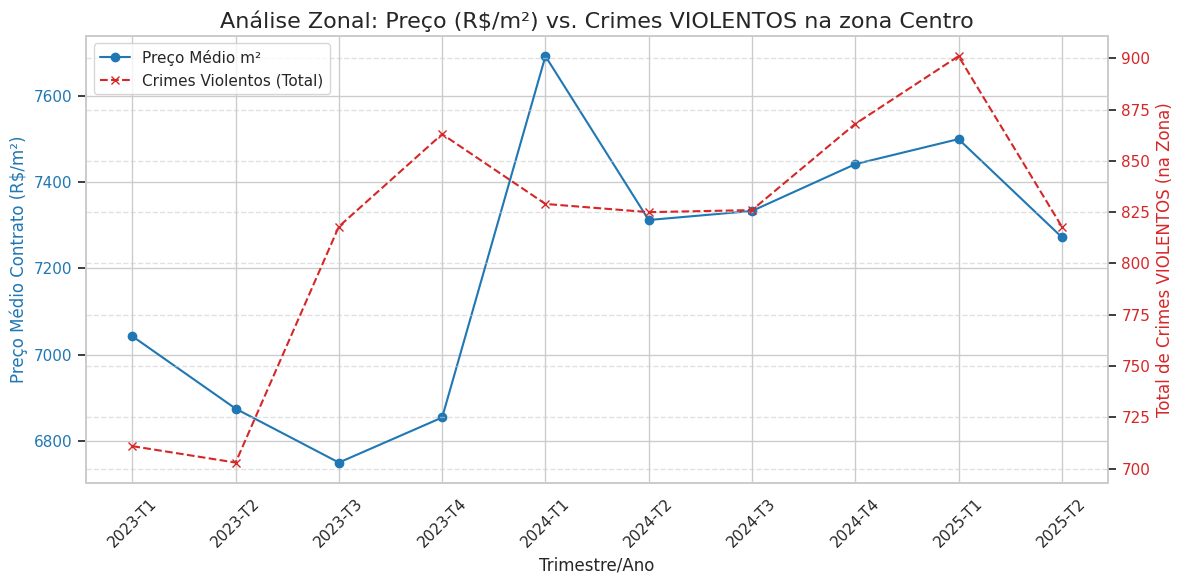


--- Gráfico para: CENTRO OESTE ---


<Figure size 1200x600 with 0 Axes>

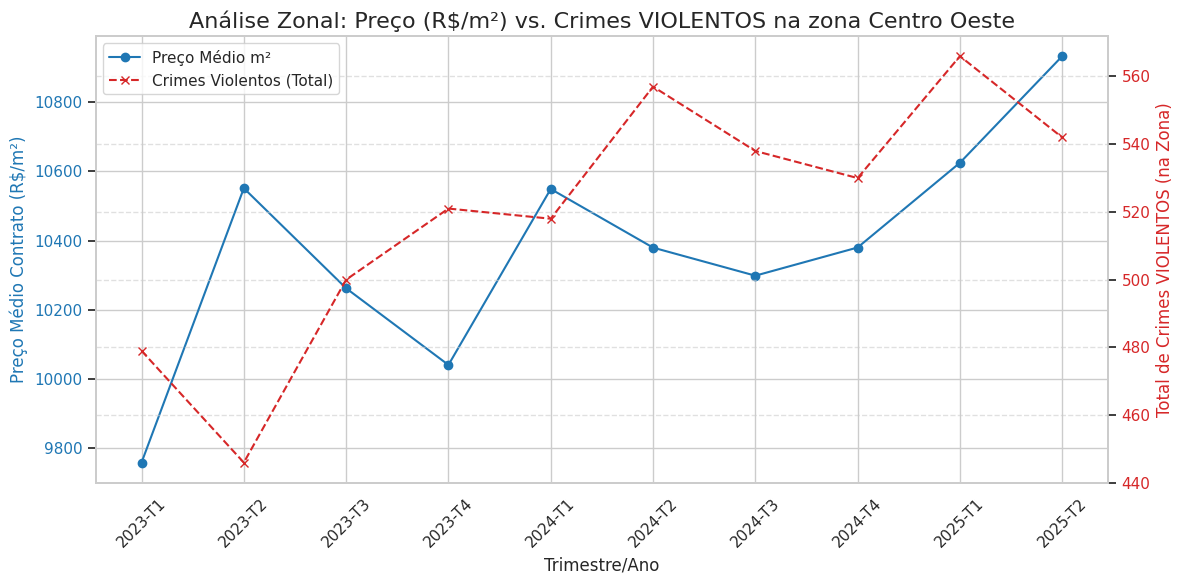


--- Gráfico para: CENTRO SUL ---


<Figure size 1200x600 with 0 Axes>

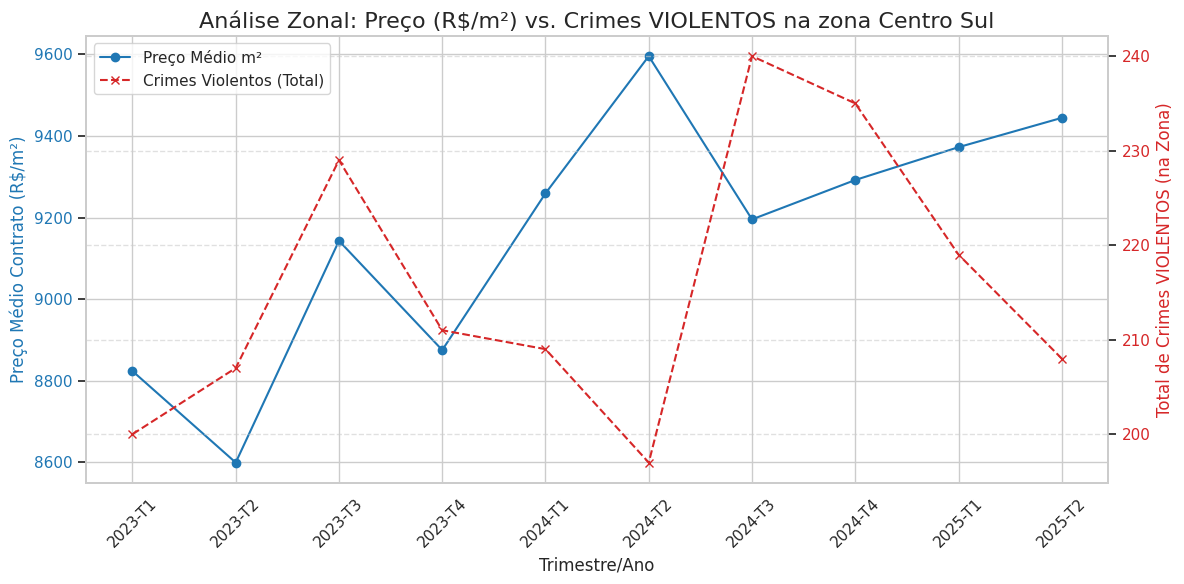


--- Gráfico para: LESTE ---


<Figure size 1200x600 with 0 Axes>

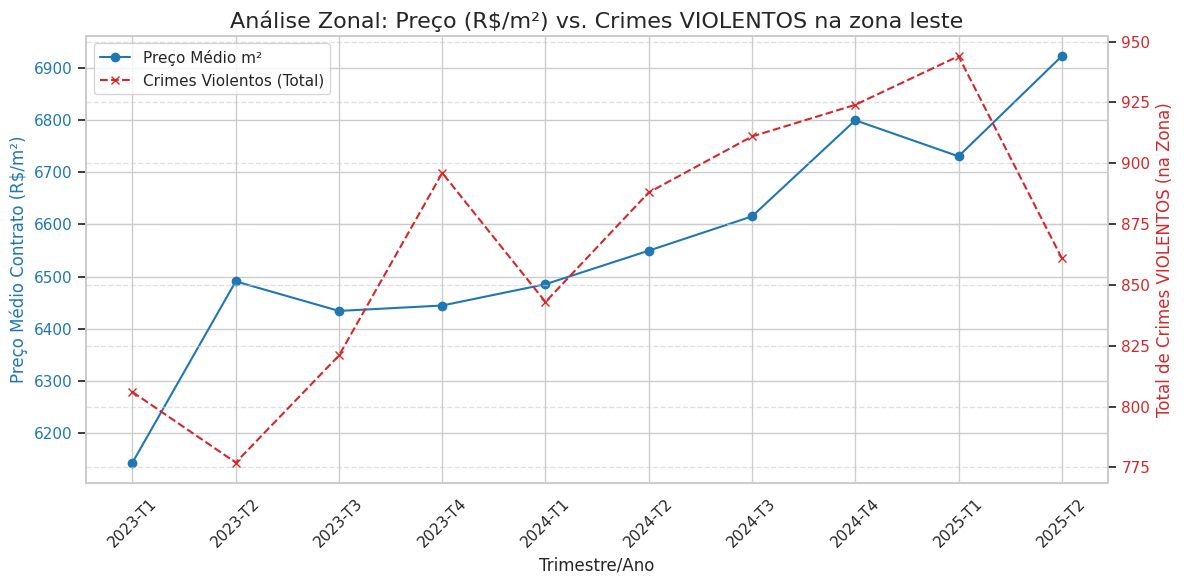


--- Gráfico para: NORTE ---


<Figure size 1200x600 with 0 Axes>

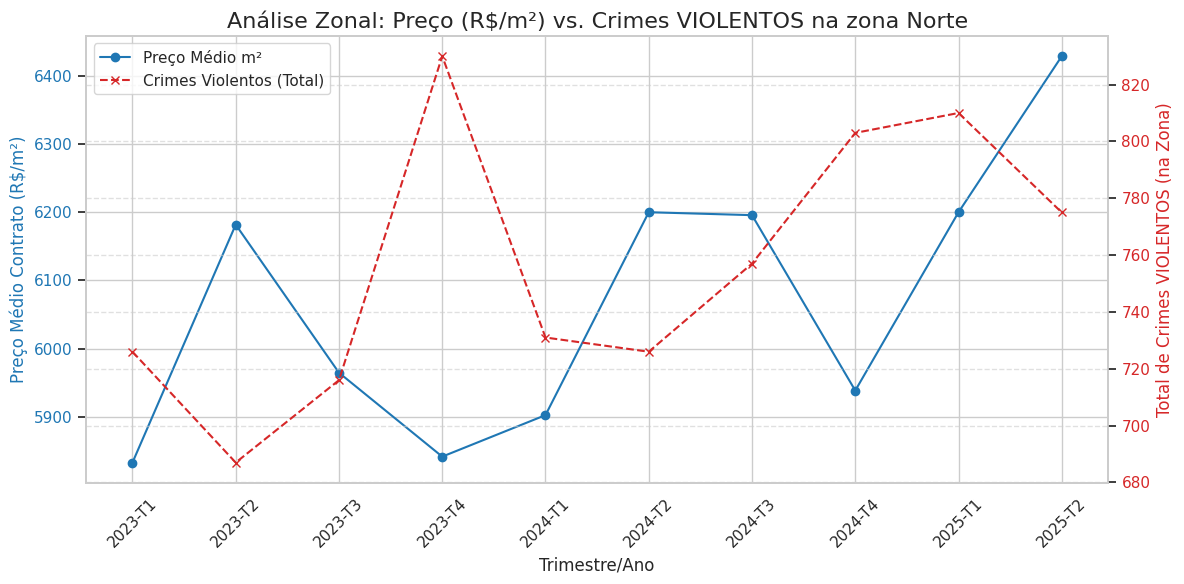


--- Gráfico para: OESTE ---


<Figure size 1200x600 with 0 Axes>

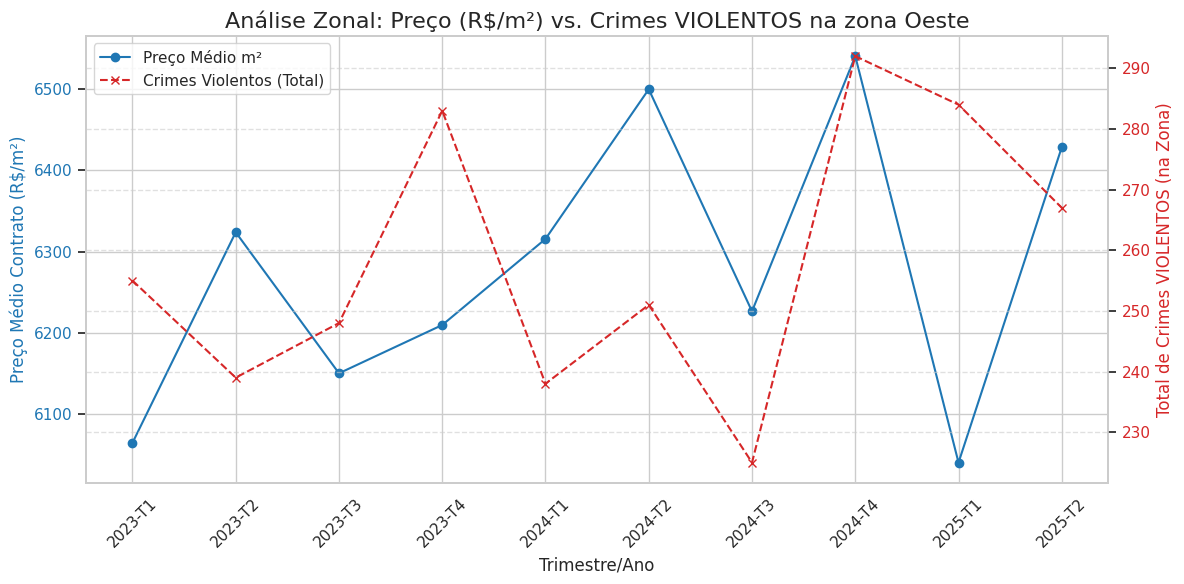


--- Gráfico para: SUL ---


<Figure size 1200x600 with 0 Axes>

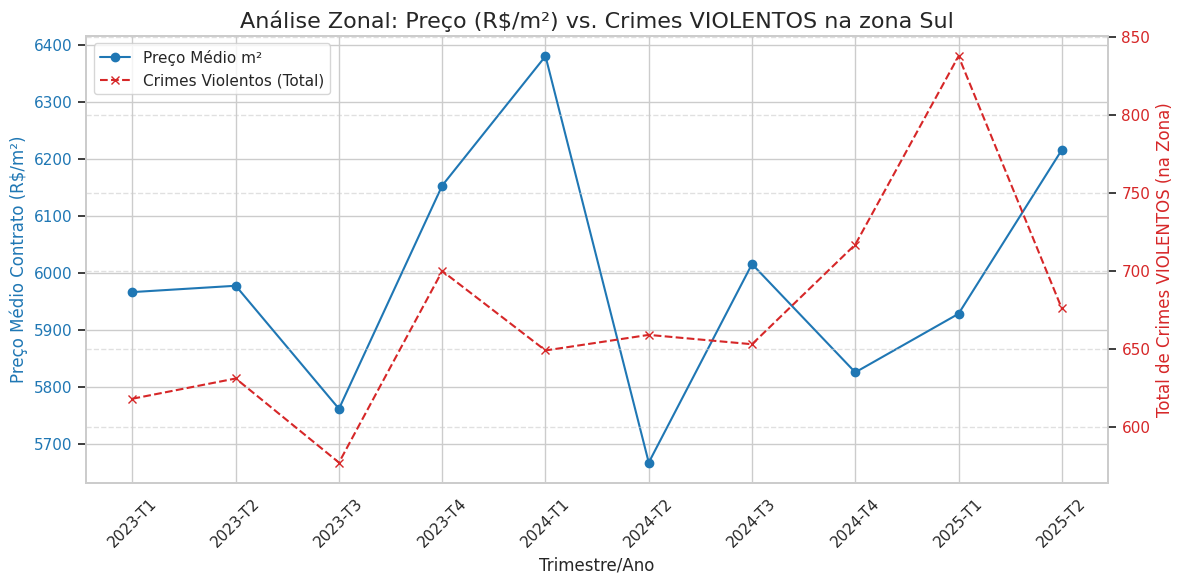


Gráficos zonais (vs. Violência) salvos e exibidos.


<Figure size 1200x600 with 0 Axes>

In [44]:
# --- ANÁLISE TEMPORAL ZONAL (PREÇO ZONAL vs. CRIME VIOLENTO) ---
# OBJETIVO: Plotar a evolução do Preço R$/m² vs. Crimes VIOLENTOS
#           em gráficos separados para cada Zona.

print("--- 1. Preparando Dados de Preço (Zonal Trimestral) ---")
# 1a) REUTILIZANDO 'precos_zonal_df' (Tabela de Preços Zonais)
# (criada na Célula 35, já com 'leste' combinado)
if 'precos_zonal_df' in locals():
    print(" Tabela de Preços Zonais (Trimestral) reutilizada.")
    display(precos_zonal_df.head())
else:
    print("ERRO CRÍTICO: 'precos_zonal_df' não foi encontrado. Rode a Célula 35 primeiro.")
    # (Parar execução se os dados de preço não existirem)
    assert 'precos_zonal_df' in locals(), "Rode a Célula 35 para criar 'precos_zonal_df'"


print("\n--- 2. Preparando Dados de Crime (Zonal Trimestral - VIOLENTOS) ---")
# (Usando o 'ocorrencias_violentos' da Célula 28 e 'mapa_distrito_zona' da Célula 35)
try:
    # 2a) Mapeia o mês para trimestre_num
    if 'mes_num' not in ocorrencias_violentos.columns:
         mapa_meses_num = {
            'janeiro': 1, 'fevereiro': 2, 'marco': 3, 'abril': 4, 'maio': 5, 'junho': 6,
            'julho': 7, 'agosto': 8, 'setembro': 9, 'outubro': 10, 'novembro': 11, 'dezembro': 12
         }
         ocorrencias_violentos['mes_num'] = ocorrencias_violentos['mes'].map(mapa_meses_num)

    if 'trimestre_num' not in ocorrencias_violentos.columns:
        ocorrencias_violentos['trimestre_num'] = ((ocorrencias_violentos['mes_num'] - 1) // 3) + 1

    # 2b) REUTILIZANDO 'mapa_distrito_zona' (criado na Célula 35)
    print("Mapa 'id_distrito' -> 'zona' reutilizado.")

    # 2c) Adiciona a 'zona' aos crimes VIOLENTOS
    crimes_violentos_com_zona = pd.merge(
        ocorrencias_violentos,
        mapa_distrito_zona,
        left_on='idDistrito', # Coluna em 'ocorrencias_violentos'
        right_on='id_distrito', # Coluna em 'mapa_distrito_zona'
        how='left'
    )
    crimes_violentos_com_zona = crimes_violentos_com_zona.dropna(subset=['zona'])

    # 2d) Agrupa o TOTAL de crimes VIOLENTOS por ZONA e por TRIMESTRE
    crimes_violentos_zonal_df = (
        crimes_violentos_com_zona.groupby(['ano', 'trimestre_num', 'zona'])['quantidade']
        .sum().reset_index() # Usamos a SOMA para os totais de crimes
        .rename(columns={'quantidade': 'total_ocorrencias_violentos_zonal'})
    )
    print(" Tabela de Crimes VIOLENTOS Zonais (Trimestral) pronta!")
    display(crimes_violentos_zonal_df.head())

except KeyError as e:
    print(f"ERRO CRÍTICO no processamento de Crimes Zonais: Coluna {e} não encontrada.")
except Exception as e:
    print(f"Erro ao processar Crimes Zonais: {e}")


print("\n--- Passo 3: Junção Final (Zonal vs. Violência) ---")
# Normalizando os nomes das zonas para o merge
precos_zonal_df['zona_lower'] = precos_zonal_df['zona'].str.lower().str.strip()
crimes_violentos_zonal_df['zona_lower'] = crimes_violentos_zonal_df['zona'].str.lower().str.strip()

analise_zonal_violencia_final = pd.merge(
    precos_zonal_df,
    crimes_violentos_zonal_df,
    on=['ano', 'trimestre_num', 'zona_lower'],
    how='inner'
)
analise_zonal_violencia_final = analise_zonal_violencia_final.rename(columns={'zona_x': 'zona'})
analise_zonal_violencia_final['trimestre_label'] = analise_zonal_violencia_final['ano'].astype(str) + '-T' + analise_zonal_violencia_final['trimestre_num'].astype(str)
analise_zonal_violencia_final = analise_zonal_violencia_final.sort_values(by=['zona_lower', 'ano', 'trimestre_num'])
print(f" Tabela Zonal (vs. Violência) Final (Trimestral) pronta! {analise_zonal_violencia_final.shape[0]} registros.")
display(analise_zonal_violencia_final.head())


# --- PASSO 4: PLOTANDO OS GRÁFICOS (ZONAL vs. VIOLÊNCIA) ---
zonas_unicas = analise_zonal_violencia_final['zona'].unique()
print(f"\n--- Gerando {len(zonas_unicas)} Gráficos Zonais (Preço vs. CRIME VIOLENTO) ---")

for zona in zonas_unicas:
    df_zona = analise_zonal_violencia_final[analise_zonal_violencia_final['zona'] == zona]

    if df_zona.empty:
        print(f"Sem dados para a zona: {zona}")
        continue

    print(f"\n--- Gráfico para: {zona.upper()} ---")
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Eixo Esquerdo (Preço)
    color = 'tab:blue'
    ax1.set_xlabel('Trimestre/Ano', fontsize=12)
    ax1.set_ylabel('Preço Médio Contrato (R$/m²)', color=color, fontsize=12)
    ax1.plot(df_zona['trimestre_label'], df_zona['preco_m2_zonal'], color=color, marker='o', label='Preço Médio m²')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', rotation=45)

    # Eixo Direito (Crimes VIOLENTOS)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Total de Crimes VIOLENTOS (na Zona)', color=color, fontsize=12)
    ax2.plot(df_zona['trimestre_label'], df_zona['total_ocorrencias_violentos_zonal'], color=color, marker='x', linestyle='--', label='Crimes Violentos (Total)')
    ax2.tick_params(axis='y', labelcolor=color)

    # Título
    plt.title(f'Análise Zonal: Preço (R$/m²) vs. Crimes VIOLENTOS na zona {zona}', fontsize=16)
    fig.tight_layout()

    # Legenda combinada
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(f"zonal_violentos_{zona.lower().replace(' ', '_')}.png", bbox_inches='tight')
    plt.show()
    plt.clf()

print("\nGráficos zonais (vs. Violência) salvos e exibidos.")

## Descoberta: O que cada Zona está dizendo para nós?

Depois de olhar para todos os gráficos zonais, começamos a perceber que cada região da cidade tem uma “personalidade própria”. É como se cada zona respondesse à criminalidade de um jeito diferente, e isso muda totalmente a forma como o mercado imobiliário dela se comporta.

Vamos caminhar por cada zona, olhando os gráficos como quem observa uma história se desenrolar diante dos olhos.



## Zona Centro: O ciclo mais claro da cidade

A Zona Centro é a mais “sincera” de todas. Aqui, preços e criminalidade praticamente caminham juntos. As curvas parecem conversar entre si.

### Crimes Patrimoniais  
Quando os preços do m² caem, alguns trimestres depois os crimes patrimoniais também diminuem. Quando os preços sobem, os crimes sobem logo depois.  
É quase um espelho com delay.

Isso faz sentido: o Centro é uma área de muito movimento, trânsito de pessoas, comércios, serviços, fluxo por todos os lados. Quando ela valoriza, mais gente circula. E onde tem mais gente, infelizmente, há mais oportunidades para crimes patrimoniais.

A queda brusca lá no final de 2025? Provavelmente é só a velha conhecida: subnotificação.

### Crimes Violentos  
Aqui o comportamento tem um sabor diferente: quem parece “responder” a quem são os preços.  
Quando a violência sobe, os preços acabam subindo depois também. Quando a violência cai, o preço recua em seguida.

Parece contraditório, mas isso mostra algo interessante: o Centro é tão estratégico e tão desejado que nem a violência consegue espantar a demanda.

### O que aprendemos com o Centro?
O Centro vive um ciclo claro em que preços e criminalidade se influenciam mutuamente. É a zona mais interligada nesse aspecto.



## Zona Sul: Sensível à violência, indiferente ao resto

A Zona Sul já conta outra história.

### Crimes Violentos  
Aqui o mercado responde rápido:  
Quando a violência diminui, os preços sobem.  
Quando a violência aumenta, os preços desanimam e começam a cair.

É uma relação direta, quase intuitiva. Crimes violentos parecem moldar o humor do mercado na Zona Sul.

### Crimes Patrimoniais  
Já com os crimes patrimoniais… nada.  
As curvas simplesmente seguem caminhos independentes.

Isso sugere que o comprador típico da Zona Sul não usa esse tipo de crime como critério importante na escolha.

### O que aprendemos com a Zona Sul?
A Zona Sul reage principalmente aos crimes violentos. Os patrimoniais praticamente não mexem a agulha do mercado.



## Zona Oeste: A Zona Sul… só que turbinada

Se a Zona Sul já era sensível à violência, a Zona Oeste pega essa lógica e intensifica.

### Crimes Violentos  
As curvas de preço e violência quase dançam a mesma coreografia — só que com alguns trimestres de atraso entre uma e outra.  
Quando a violência sobe, em seguida o preço cai.  
Quando a violência cai, em seguida o preço sobe.

É uma resposta muito forte, muito clara.

Isso faz sentido: a Zona Oeste concentra alguns bairros mais valorizados da cidade, com empreendimentos sofisticados. Nesses lugares, a percepção de segurança pesa muito.

### Crimes Patrimoniais  
Assim como na Zona Sul, o comportamento é praticamente aleatório.  
O preço do m² segue sua própria trajetória, alheio aos crimes patrimoniais.

### O que aprendemos com a Zona Oeste?
É a zona onde o impacto da violência é mais evidente. Quase tudo ali responde à criminalidade violenta, e quase nada responde à patrimonial.



## Zona Norte: O oposto da Zona Sul e da Oeste

Aqui o comportamento vira de cabeça para baixo.

### Crimes Violentos  
Não há padrão claro. Em alguns momentos parece que violência alta coincide com preços baixos, mas isso não se repete ao longo da série. Ou seja: não dá para afirmar relação consistente.

### Crimes Patrimoniais  
Aqui sim existe uma relação muito forte.  
Os crimes patrimoniais sobem e logo depois o preço sobe também.  
Os crimes caem e logo depois o preço diminui.

É quase o mesmo comportamento que vimos no Centro. A zona parece reagir ao movimento do comércio e da circulação.

### O que aprendemos com a Zona Norte?
O mercado daqui é claramente influenciado por crimes patrimoniais, mas não pelos violentos.



## Zona Leste: A zona mais estável (e mais independente)

A Zona Leste conta a história mais tranquila de todas.

### Crimes Violentos  
Mesmo quando a violência oscila, o preço do m² segue quase em linha reta. É impressionantemente estável.

O mercado simplesmente não reage aos crimes violentos.

### Crimes Patrimoniais  
Os crimes patrimoniais ficam altos quase o tempo inteiro, mas isso não impede o preço de subir devagar e constantemente.

A única exceção crítica aparece no final de 2024, quando há uma queda súbita nos crimes e, pouco depois, um salto no preço. Mas isso ainda é pouco para sugerir relação.

### O que aprendemos com a Zona Leste?
É a zona com menor evidência de influência da criminalidade sobre os preços. Qualquer relação mais firme depende de dados futuros.


## Conclusão Final

Quando começamos este estudo, nossa pergunta parecia simples:
>**A criminalidade interfere no preço dos imóveis da cidade?**

Mas, ao longo do caminho, descobrimos que essa resposta não só não é simples, como depende profundamente de como cada parte da cidade “respira”.

Organizamos e padronizamos os dados, conectamos preços e criminalidade por distrito e, passo a passo, transformamos planilhas fragmentadas em uma história compreensível sobre a cidade. Só depois dessa base estruturada foi possível comparar regiões, observar tendências e entender como cada zona reage ao tema central da pesquisa.

No fim, o grande aprendizado é que **não existe uma única relação entre segurança e preço**. Cada zona da cidade responde de um jeito próprio. O Centro e a Norte mostram forte ligação com crimes patrimoniais. A Sul e a Oeste reagem principalmente aos crimes violentos. Já a Leste segue seu próprio ritmo, quase independente das oscilações de segurança.

Em resumo: a criminalidade influencia o mercado imobiliário, mas nunca da mesma forma em todos os lugares. Entender essas diferenças é essencial para interpretar a cidade de maneira mais realista, para políticas públicas, planejamento urbano e até mesmo para quem pensa em comprar ou investir.


O trabalho não encerra o assunto, mas abre portas para investigações futuras. Com mais dados e séries mais longas, poderíamos explorar sazonalidade, diferenciação entre bairros dentro das zonas, tipos de empreendimento e até impactos de políticas de segurança. Mas, para o objetivo desta pesquisa, conseguimos construir uma narrativa sólida, transparente e apoiada em evidências.
